In [1]:
import os
import sys
import numpy as np
from pathlib import Path
from time import time
import pickle
import logging
from astropy.table import Table
import orpheus
from matplotlib import pyplot as plt

In [615]:
dotomo=True
fthin = 5
data = Table.read("/cosma7/data/dp004/dc-port3/Data/SLICS/KiDS450/GalCatalog_LOS1.fits")
pos1 = data["x_arcmin"].data
pos2 = data["y_arcmin"].data
gamma1 = data["shear1"].data
gamma2 = data["shear2"].data
e1 = data["eps_obs1"].data
e2 = data["eps_obs2"].data
zspec = data["z_spectroscopic"].data
zphot = data["z_photometric"].data
zbin = np.zeros(len(pos1),dtype=np.int32)
if dotomo:
    zbin[zphot<=0.25] = 0 
    zbin[(zphot>0.25)*(zphot<=0.5)] = 0
    zbin[(zphot>0.5)*(zphot<=0.75)] = 1
    zbin[(zphot>0.75)*(zphot<=1.)] = 2
    zbin[zphot>1.] = 2
    
slicsfullreso = orpheus.SpinTracerCatalog(spin=2, pos1=pos1[::fthin], pos2=pos2[::fthin], 
                                          tracer_1=gamma1[::fthin], tracer_2=gamma2[::fthin], zbins=zbin[::fthin])
print("We have %i galaxies in the mock catalog"%slicsfullreso.ngal)

We have 614161 galaxies in the mock catalog


In [610]:
dpixs = [0.25, 0.5, 1.0, 2.0, 4.0]
mhash = slicsfullreso.multihash(dpixs)
#ngal_resos, pos1s, pos2s, weights, zbins, allfields, index_matchers, pixs_galind_bounds, pix_gals, dpixs1_true, dpixs2_true = mhash
ngal_resos, pos1s, pos2s, weights, zbins, isinners, allfields, index_matchers, pixs_galind_bounds, pix_gals, dpixs1_true, dpixs2_true = mhash

First spatialhash
3 (array([ 2.3887389e-06,  9.0160602e-06,  2.9321502e-05, ...,
       -1.8608868e-02,  5.1830737e-03,  5.4329624e-03]), array([ 1.7337958e-06,  1.3832255e-05, -6.0476112e-05, ...,
       -8.6770132e-03, -2.9979378e-02,  2.7184695e-02]), array([1., 1., 1., ..., 1., 1., 1.]))
Doing reso 0
Done reso 0
Doing reso 1
Done reso 1
Doing reso 2
Done reso 2
Doing reso 3
Done reso 3
Doing reso 4
Done reso 4


In [611]:
print(ngal_resos)
print(dpixs1_true)

[3070801, 2775359, 2111735, 977891, 269906, 67500]
[0.2499999  0.4999998  0.99999959 1.99999919 3.99999837]


In [616]:
n_cfs = 4
min_sep = 0.5
max_sep_disc = 5.
max_sep = 200.
rmin_pixsize=10
rmin_pixsize20=20
dpixs = [0.,0.25,0.5,1.0,2.0]
binsize=.1

nthreads = 16

In [617]:
threepcf_disc = orpheus.GGGCorrelation(n_cfs=n_cfs, min_sep=min_sep, max_sep=50., binsize=binsize, method="Discrete")
threepcf_tree = orpheus.GGGCorrelation(n_cfs=n_cfs, min_sep=min_sep, max_sep=max_sep, tree_resos=dpixs, multicountcorr=True,
                                       binsize=binsize, rmin_pixsize=rmin_pixsize, method="Tree")
#threepcf_fulltree10 =s orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=64., nbinsr=35, rmin_pixsize=10, method="Tree")
threepcf_dtree = orpheus.GGGCorrelation(n_cfs=n_cfs, min_sep=min_sep, max_sep=max_sep, tree_resos=dpixs, multicountcorr=True,
                                       binsize=None, rmin_pixsize=rmin_pixsize,  method="DoubleTree", nbinsr=60)
threepcf_dtree20 = orpheus.GGGCorrelation(n_cfs=n_cfs, min_sep=min_sep, max_sep=max_sep, tree_resos=dpixs, multicountcorr=True,
                                       binsize=binsize, rmin_pixsize=rmin_pixsize20,  method="DoubleTree")
threepcf_dtreenodc = orpheus.GGGCorrelation(n_cfs=n_cfs, min_sep=min_sep, max_sep=max_sep, tree_resos=dpixs, multicountcorr=False,
                                       binsize=binsize, rmin_pixsize=rmin_pixsize,  method="DoubleTree")

In [618]:
%%time
# Timings for notomo: rmin_pixsize=10
# Full calc --> 3m3 (now 4m4 vs 4m46)
# No multireso Gamma alloc --> 2m42s
# No singlereso Gamma alloc --> 2m48s
# No Gncache alloc --> 1m58s

# Timings for 2 tomo bins: rmin_pixsize=10 (20)
# Full calc --> 8m57 (expected: 1*2^2 + (1/3+1/6)*2^3 + 1.5 = 9m30)
# No multireso Gamma alloc --> 7m25 (expected: 1*2^2 + (1/6)*2^3 + 1.5 = 6m50)
# No singlereso Gamma alloc --> 6m28(expected: 1*2^2 + (1/3)*2^3 + 1.5 = 8m10)
# No Gncache alloc --> 5m41 (expected: xxxx(1/3)*2^3 + 1.5 = 5m30)
# ---> 8m57 - 1m32 - 2m39 - 3m16 = 1m30
threepcf_dtree.process(slicsfullreso, nthreads=nthreads, dotomo=dotomo, apply_edge_correction=False)

Doing multihash
[0.25 0.5  1.   2.  ]
First spatialhash
3 (array([ 2.3887389e-06,  6.8996080e-05, -1.7467614e-04, ...,
       -1.0910943e-01, -6.6369817e-02,  5.4329624e-03]), array([ 1.7337958e-06,  8.2187980e-05, -1.7638942e-05, ...,
        2.8178744e-02,  7.7342227e-02,  2.7184695e-02]), array([1., 1., 1., ..., 1., 1., 1.]))
Doing reso 0
Done reso 0
Doing reso 1
Done reso 1
Doing reso 2
Done reso 2
Doing reso 3
Done reso 3
Done multihash
[0.24999945 0.49999889 0.99999778 1.99999557] [614161, 601704, 566356, 452472, 231269] 5
1.2452766912061095 1.0 1.2452766912061095
Doing DoubleTree
CPU times: user 3h 58min 36s, sys: 39.7 s, total: 3h 59min 16s
Wall time: 16min 22s


In [475]:
threepcf_dtree.rmin_pixsize
(4*60+15)/16

15.9375

In [ ]:
%%time
threepcf_dtree20.process(slicsfullreso, nthreads=nthreads, dotomo=dotomo, apply_edge_correction=False)

In [325]:
%%time
threepcf_disc.process(slicsfullreso, nthreads=16, dotomo=dotomo)

CPU times: user 1h 15min 3s, sys: 5.76 s, total: 1h 15min 8s
Wall time: 5min 4s


In [72]:
%%time
threepcf_tree.process(slicsfullreso, nthreads=nthreads, dotomo=dotomo)

Doing multihash
[0.25 0.5  1.   2.   4.  ]
First spatialhash
Doing reso 0
Done reso 0
Doing reso 1
Done reso 1
Doing reso 2
Done reso 2
Doing reso 3
Done reso 3
Doing reso 4
Done reso 4
Done multihash
[0.24999866 0.49999732 0.99999465 1.99998929 3.99997858] [307081, 299100, 276706, 206381, 86996, 22500] 6
Doing Tree
CPU times: user 22min 47s, sys: 2.92 s, total: 22min 50s
Wall time: 1min 40s


In [165]:
%%time
threepcf_disc.multipoles2npcf()

CPU times: user 340 ms, sys: 5.98 ms, total: 346 ms
Wall time: 344 ms


In [14]:
%%time
threepcf_tree.multipoles2npcf()

CPU times: user 613 ms, sys: 2 ms, total: 615 ms
Wall time: 613 ms


In [9]:
%%time
threepcf_dtree.multipoles2npcf()

CPU times: user 1.11 s, sys: 10.2 ms, total: 1.12 s
Wall time: 1.12 s


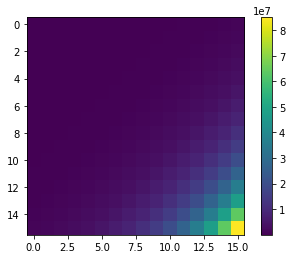

In [166]:
plt.imshow(threepcf_disc.npcf_multipoles_norm[0,0].real)
plt.colorbar()

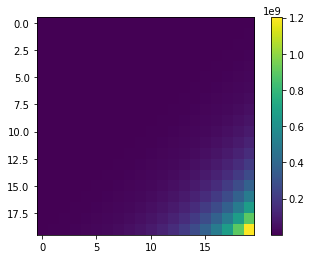

In [16]:
plt.imshow(threepcf_tree.npcf_multipoles_norm[0,0][:20,:20].real)
plt.colorbar()

In [27]:
print(threepcf_dtree.tree_nresos)
print(threepcf_dtree.tree_resos)
print(threepcf_dtree.tree_redges)

4
[0.  0.5 1.  2. ]
[  0.5  10.   20.   40.  200. ]


In [28]:
print(len(threepcf_dtree.tree_resosatr), len(threepcf_dtree.bin_edges))
print(threepcf_dtree.tree_resosatr)

60 61
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


IndexError: index 1 is out of bounds for axis 0 with size 1

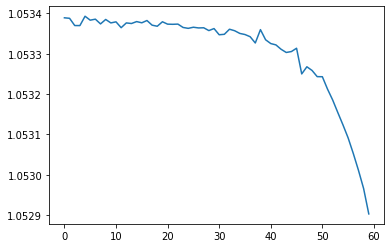

In [10]:
plt.plot(threepcf_dtree.bin_centers[0]/threepcf_dtree.bin_edges[:-1])
plt.plot(threepcf_dtree.bin_centers[1]/threepcf_dtree.bin_edges[:-1])
plt.plot(1+.5*(threepcf_dtree.bin_edges[1:]/threepcf_dtree.bin_edges[:-1]-1))

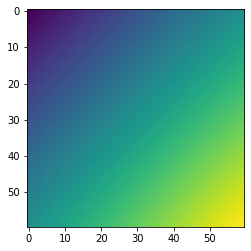

In [17]:
plt.imshow(np.log10(threepcf_dtree.npcf_multipoles_norm[0,0].real))

0 0 0


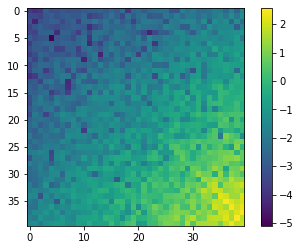

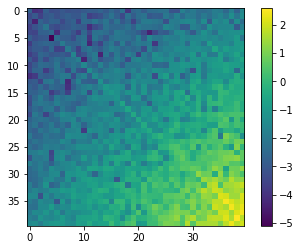

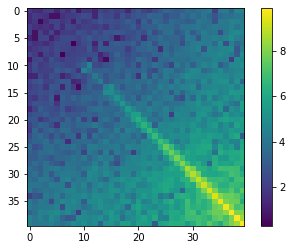

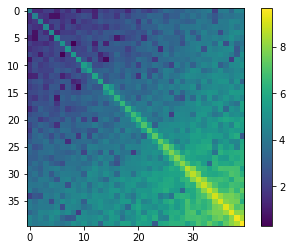

0 1 1


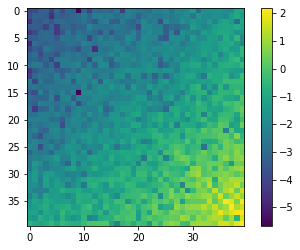

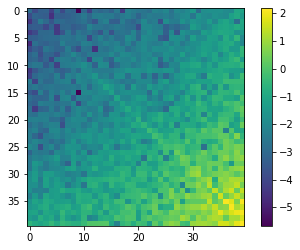

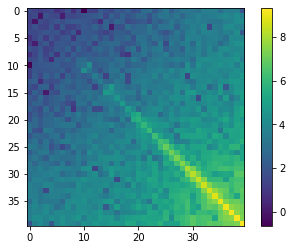

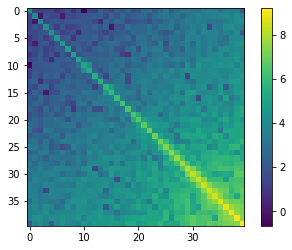

0 2 2


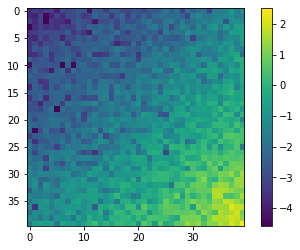

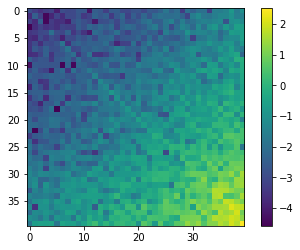

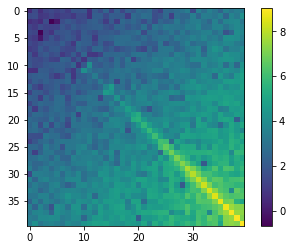

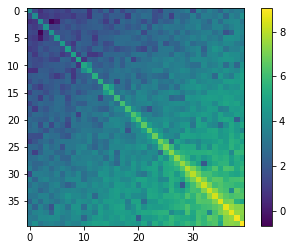

1 0 0


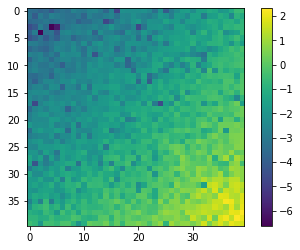

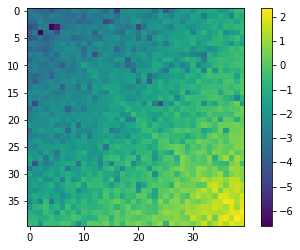

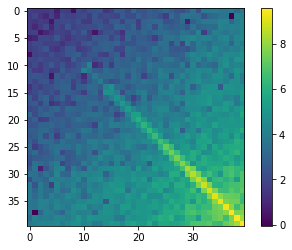

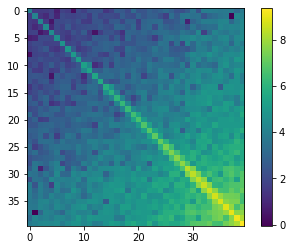

1 1 1


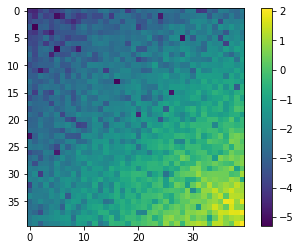

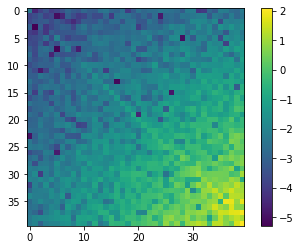

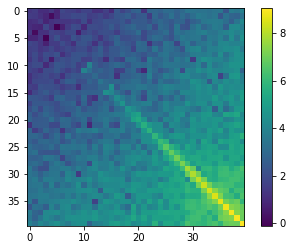

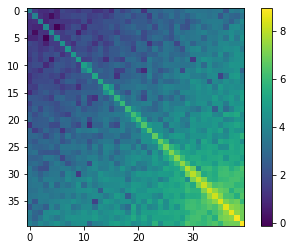

1 2 2


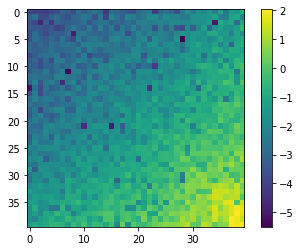

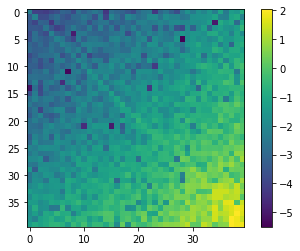

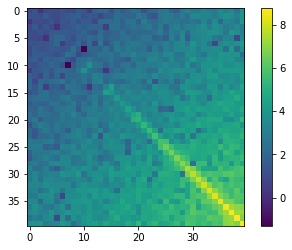

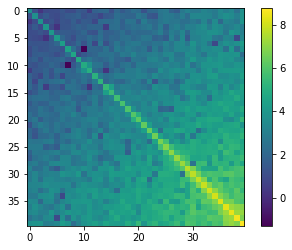

2 0 0


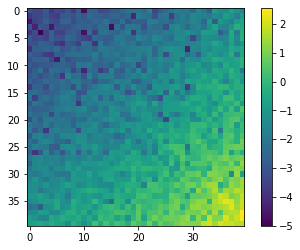

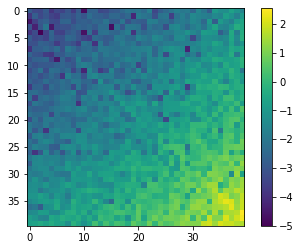

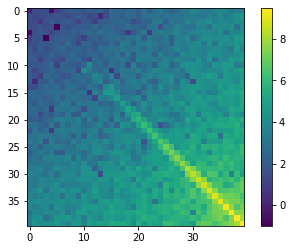

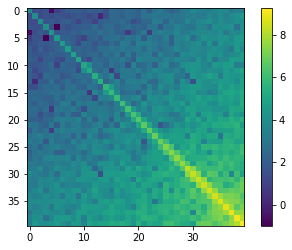

2 1 1


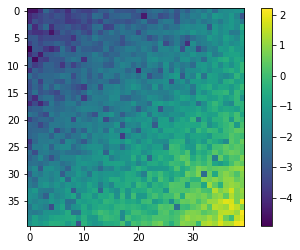

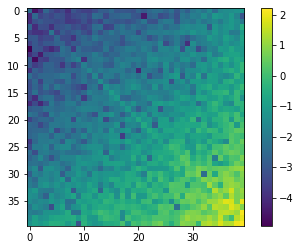

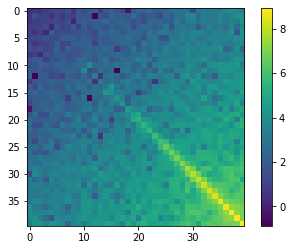

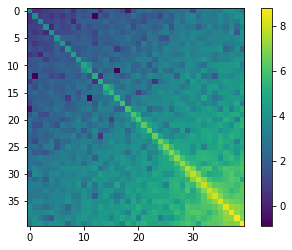

2 2 2


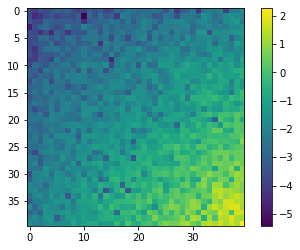

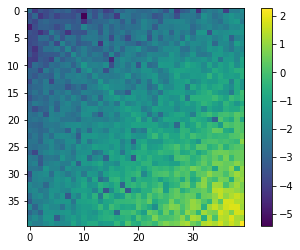

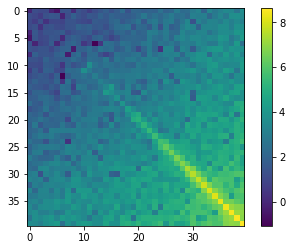

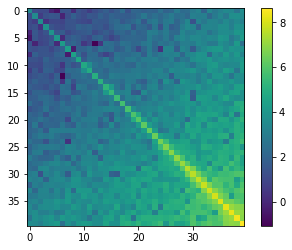

In [20]:
nbinsz = threepcf_dtree.nbinsz
eln = 20
elcomp = 0
for elz1 in range(0, nbinsz):
    for elz2 in range(0, nbinsz):
        for elz3 in range(0, nbinsz):
            if elz2==elz3:
                zcombi = elz1*nbinsz*nbinsz + elz2*nbinsz + elz3
                print(elz1, elz2, elz3)
                plt.imshow(np.log10(np.abs(threepcf_dtree.npcf_multipoles[elcomp,eln,zcombi].real)))
                plt.colorbar()
                plt.show()
                plt.imshow(np.log10(np.abs(threepcf_dtreenodc.npcf_multipoles[elcomp,eln,zcombi].real)))
                plt.colorbar()
                plt.show()
                plt.imshow(np.log10(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,zcombi].real)))
                plt.colorbar()
                plt.show()
                plt.imshow(np.log10(np.abs(threepcf_dtreenodc.npcf_multipoles_norm[eln,zcombi].real)))
                plt.colorbar()
                plt.show()
                #plt.imshow(np.log10(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,zcombi].real)))
                #plt.colorbar()
                #plt.show()
                #plt.imshow(np.log10(np.abs(threepcf_tree.npcf_multipoles_norm[eln,zcombi].real)))
                #plt.colorbar()
                #plt.show()

0 0 0


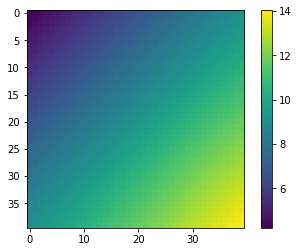

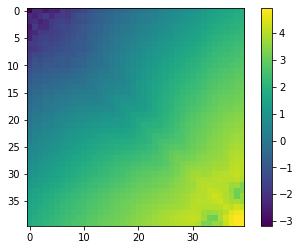

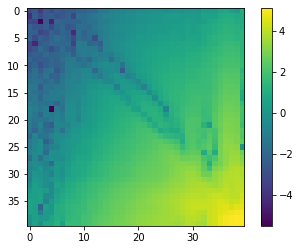

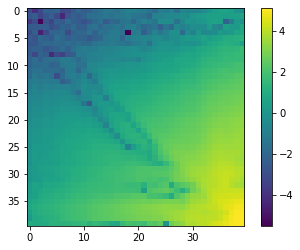

In [29]:
nbinsz = threepcf_dtree10.nbinsz
eln = 0
for elz1 in range(0, nbinsz):
    for elz2 in range(0, nbinsz):
        for elz3 in range(0, nbinsz):
            zcombi = elz1*nbinsz*nbinsz + elz2*nbinsz + elz3
            print(elz1, elz2, elz3)
            plt.imshow(np.log10(np.abs(threepcf_dtree10.npcf_multipoles_norm[eln,zcombi].real)))
            plt.colorbar()
            plt.show()
            plt.imshow(np.log10(np.abs(threepcf_dtree10.npcf_multipoles[1,eln,zcombi].real)))
            plt.colorbar()
            plt.show()
            plt.imshow(np.log10(np.abs(threepcf_dtree10.npcf_multipoles[2,eln,zcombi].real)))
            plt.colorbar()
            plt.show()
            plt.imshow(np.log10(np.abs(threepcf_dtree10.npcf_multipoles[3,eln,zcombi].real)))
            plt.colorbar()
            plt.show()

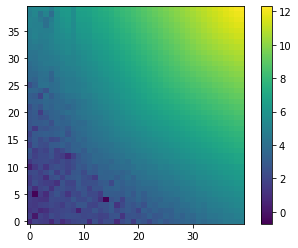

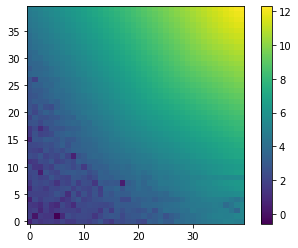

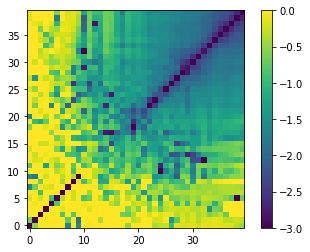

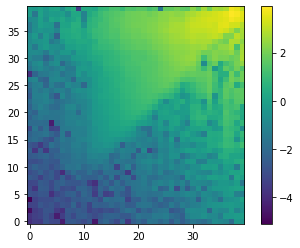

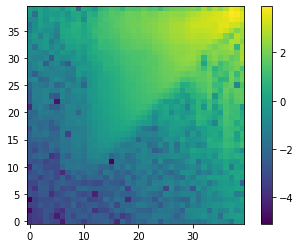

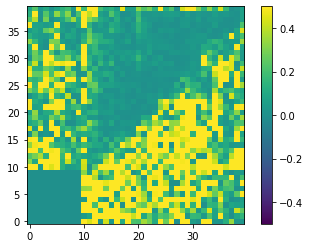

In [27]:
zcombi = 2
nmulti = 1
elcomp = 0

plt.imshow(np.log10(np.abs(threepcf_tree.npcf_multipoles_norm[nmulti,zcombi].real)), origin="lower")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(threepcf_dtree.npcf_multipoles_norm[nmulti,zcombi].real)), origin="lower")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(threepcf_tree.npcf_multipoles_norm[nmulti,zcombi].real/threepcf_dtree.npcf_multipoles_norm[nmulti,zcombi].real-1)),
           vmin=-3,vmax=0, origin="lower")
plt.colorbar()
plt.show()


plt.imshow(np.log10(np.abs(threepcf_tree.npcf_multipoles[elcomp,nmulti,zcombi].real)),origin="lower")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(threepcf_dtree.npcf_multipoles[elcomp,nmulti,zcombi].real)),  origin="lower")
plt.colorbar()
plt.show()

plt.imshow(np.abs(threepcf_tree.npcf_multipoles[elcomp,nmulti,zcombi].real/threepcf_dtree.npcf_multipoles[elcomp,nmulti,zcombi].real-1),
           vmin=-0.5,vmax=0.5, origin="lower")
plt.colorbar()
plt.show()


In [31]:
threepcf_dtree.npcf_multipoles.shape

(4, 31, 1, 39, 39)

In [38]:
threepcf_dtree.npcf_multipoles.shape

(4, 31, 27, 39, 39)

In [ ]:
redges = np.geomspace(0.5,200,41)
target_edges = [0.5, 5., 10., 20., 40., 80.]
for elr, r in range(redges):
    

In [29]:
import treecorr
import time

In [182]:
n_cfs = 4
min_sep = 0.5
max_sep_disc = 5.
max_sep = 200.
rmin_pixsize=20
dpixs = [0.,0.25,0.5,1.0,2.0,4.0]
binsize=.15
nthreads = 16
fthin = 1


ggg_bs0p1 = treecorr.GGGCorrelation(bin_size=binsize, min_sep=min_sep, max_sep=max_sep, max_n=30, bin_slop=0.1,
                               verbose=2, num_threads=nthreads, bin_type='LogMultipole')
ggg_bsbase = treecorr.GGGCorrelation(bin_size=binsize, min_sep=min_sep, max_sep=max_sep, max_n=30, 
                               verbose=2, num_threads=nthreads, bin_type='LogMultipole')

sel_z1 = zbin[::fthin]==0
sel_z2 = zbin[::fthin]==1
sel_z3 = zbin[::fthin]==2
cat = treecorr.Catalog(x=pos1[::fthin], y=pos2[::fthin], g1=gamma1[::fthin], g2=gamma2[::fthin], verbose=2)
#cat1 = treecorr.Catalog(x=pos1[::fthin][sel_z1], y=pos2[::fthin][sel_z1], g1=gamma1[::fthin][sel_z1], g2=gamma2[::fthin][sel_z1], verbose=2)
#cat2 = treecorr.Catalog(x=pos1[::fthin][sel_z2], y=pos2[::fthin][sel_z2], g1=gamma1[::fthin][sel_z2], g2=gamma2[::fthin][sel_z2], verbose=2)
#cat3 = treecorr.Catalog(x=pos1[::fthin][sel_z3], y=pos2[::fthin][sel_z3], g1=gamma1[::fthin][sel_z3], g2=gamma2[::fthin][sel_z3], verbose=2)

r: nbins = 40, min,max sep = 0.5..200, bin_size = 0.149787
r: nbins = 40, min,max sep = 0.5..200, bin_size = 0.149787
   nobj = 3070801


In [39]:
t1 = time.time()
ggg_bs0p1.process(cat)
t2 = time.time()
print(t2-t1)

Starting process GGG auto-correlations
Using 16 threads.
Building GField
Starting 1024 jobs.
varg = 0.000180: sig_g = 0.013427
258.55519247055054


In [183]:
t1 = time.time()
ggg_bsbase.process(cat)
t2 = time.time()
print(t2-t1)

Starting process GGG auto-correlations
Using 16 threads.
Building GField
Starting 256 jobs.
varg = 0.000181: sig_g = 0.013439
449.41558289527893


In [185]:
gggsas_bs0p1 = ggg_bs0p1.toSAS(phi_bin_size=0.1)
gggsas_bsbase = ggg_bsbase.toSAS()

r: nbins = 40, min,max sep = 0.5..200, bin_size = 0.149787
r: nbins = 40, min,max sep = 0.5..200, bin_size = 0.149787


/cosma/home/dp004/dc-port3/.local/lib/python3.7/site-packages/treecorr/gggcorrelation.py:793: RuntimeWarning: divide by zero encountered in log
  sas.meanlogd1[:] = np.log(sas.meand1)
/cosma/home/dp004/dc-port3/.local/lib/python3.7/site-packages/treecorr/gggcorrelation.py:844: RuntimeWarning: invalid value encountered in true_divide
  g2phase /= np.abs(g2phase)
/cosma/home/dp004/dc-port3/.local/lib/python3.7/site-packages/treecorr/gggcorrelation.py:845: RuntimeWarning: invalid value encountered in true_divide
  g3phase /= np.abs(g3phase)
/cosma/home/dp004/dc-port3/.local/lib/python3.7/site-packages/treecorr/gggcorrelation.py:871: RuntimeWarning: invalid value encountered in true_divide
  ratio = self.ntri[:,:,0] / np.sum(sas.weight, axis=2) * phi_frac


In [186]:
map3R = np.geomspace(0.5,30,20)
map3s_bs0p1 = gggsas_bs0p1.calculateMap3(R=map3R)
map3s_bsbase = gggsas_bsbase.calculateMap3(R=map3R)

In [86]:
map3s_dpix10 = threepcf_dtree10.computeMap3(radii=map3R, do_multiscale=False, tofile=False, filtercache=None)
map3s_dpix20 = threepcf_dtree20.computeMap3(radii=map3R, do_multiscale=False, tofile=False, filtercache=None)
map3s_dpix10tree = threepcf_tree.computeMap3(radii=map3R, do_multiscale=False, tofile=False, filtercache=None)

AssertionError: 

In [96]:
gggsas_bsbase.gam0r.shape

(40, 40, 30)

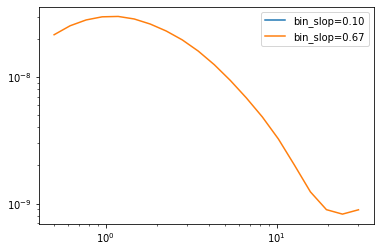

In [191]:
plt.loglog(map3R, map3s_bs0p1[0], label="bin_slop=%.2f"%gggsas_bs0p1.bin_slop)
plt.loglog(map3R, map3s_bsbase[0], label="bin_slop=%.2f"%gggsas_bsbase.bin_slop)
#plt.loglog(map3R, map3s_dpix10[0,0], label="dpix_min=10")
#plt.loglog(map3R, map3s_dpix20[0,0], label="dpix_min=20")
#plt.loglog(map3R, map3s_dpix10tree[0,0], label="tree,dpix_min=20")

plt.legend()

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


/cosma/local/pythonconda3/2020-02/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


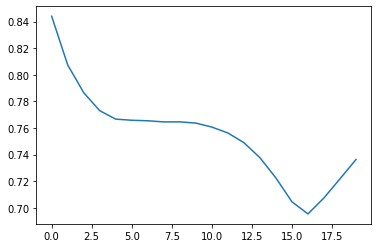

In [190]:
print(map3s_bs0p1[0]/map3s_bsbase[0])
plt.plot(map3s_bsbase[0]/map3s[0,0])

In [37]:
bin_edges = np.array([0.5,          0.58079317,   0.67464142,   0.78365427,  0.9102821,
   1.05737126,   1.22822803,   1.42669291,   1.65722701,   1.92501227,
   2.23606798,   2.59738604,   3.01708817,   3.50460843,   4.07090532,
   4.72870805,   5.49280272,   6.38036466,   7.41134449,   8.60891659,
  10.        ,  11.6158635 ,  13.49282848,  15.67308538,  18.20564203,
  21.14742527,  24.56456052,  28.53385819,  33.14454017,  38.50024543,
  44.72135955,  51.94772079,  60.34176337,  70.09216864,  81.41810631,
  94.5741609 , 109.85605433, 127.60729314, 148.22688982, 172.17833187, 200. ])

In [60]:
threepcf_dtree20.projection

'Centroid'

In [40]:
np.log(bin_edges[1:]/bin_edges[:-1])

array([0.14978661, 0.14978662, 0.14978662, 0.14978661, 0.14978661,
       0.14978662, 0.14978661, 0.14978661, 0.14978661, 0.14978662,
       0.14978661, 0.14978661, 0.14978661, 0.14978662, 0.14978661,
       0.14978661, 0.14978661, 0.14978661, 0.14978661, 0.14978661,
       0.14978661, 0.14978661, 0.14978661, 0.14978661, 0.14978661,
       0.14978661, 0.14978661, 0.14978661, 0.14978661, 0.14978661,
       0.14978661, 0.14978661, 0.14978661, 0.14978661, 0.14978661,
       0.14978661, 0.14978661, 0.14978661, 0.14978661, 0.14978661])

In [43]:
threepcf_tree.binsize

0.14978661367769963

(array([197.,   0.,   0.,   0.,   0., 180., 200., 152.,  50.]),
 array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
        2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ]),
 <a list of 9 Patch objects>)

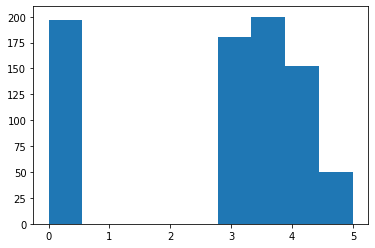

In [95]:
plt.hist((threepcf_tree.npcf_multipoles_norm[nmulti,zcombi].real/threepcf_dtree.npcf_multipoles_norm[nmulti,zcombi].real-1).flatten(),bins=np.linspace(0,5,10))

In [439]:
%%time
map3s = threepcf_dtree10.computeMap3(radii=map3R, do_multiscale=False, tofile=False, filtercache=None)
#map3s = threepcf_disc.computeMap3(radii=map3R, do_multiscale=False, tofile=False, filtercache=None)

CPU times: user 8.77 s, sys: 36.9 ms, total: 8.81 s
Wall time: 8.82 s


In [11]:
grid = threepcf_dtree._map3_filtergrid_singleR(1,1,1)

In [11]:
threepcf_dtree10.npcf.shape

(4, 1, 40, 40, 100)

In [16]:
np.nansum(T0*threepcf_dtree.npcf[0,...],axis=(1,2,3))

array([1.76128096e-08-9.82114109e-10j, 2.93687498e-08+8.04379599e-10j,
       2.93687498e-08+8.04379599e-10j, 5.13879495e-08-5.51937894e-10j,
       2.95608047e-08+6.57914413e-10j, 4.90842325e-08-3.67879619e-10j,
       4.90842325e-08-3.67879619e-10j, 7.72910629e-08-2.17297960e-10j])

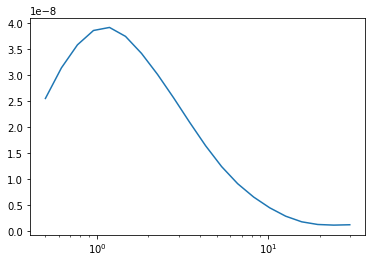

In [180]:
# No ec 
for i in range(1):
    plt.semilogx(map3R, map3s[i,0].real)
plt.show()

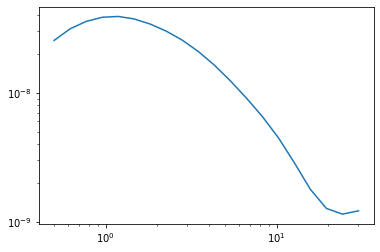

In [195]:
# No ec 
for i in range(1):
    plt.loglog(map3R, np.abs(map3s[i,0].real))
plt.show()

0 0 0


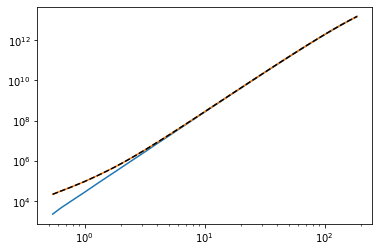

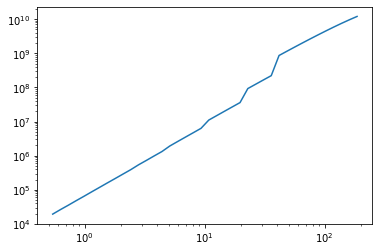

0 0 1


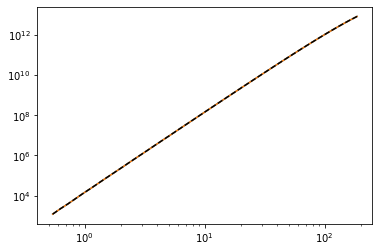

0 0 2


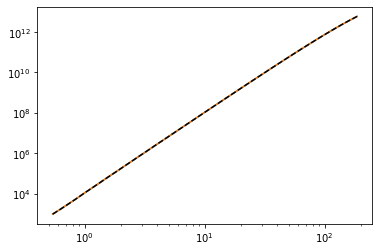

0 1 0


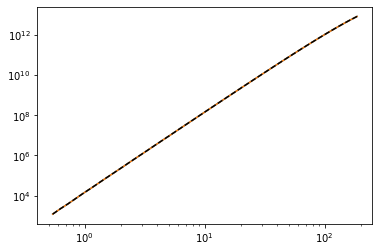

0 1 1


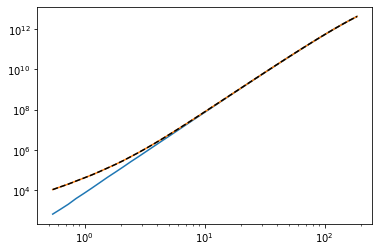

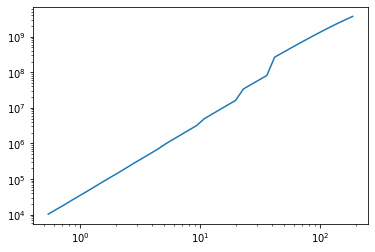

0 1 2


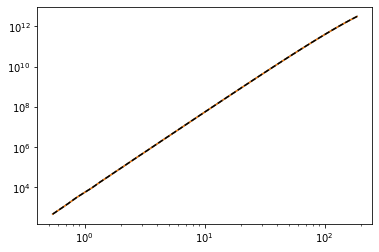

0 2 0


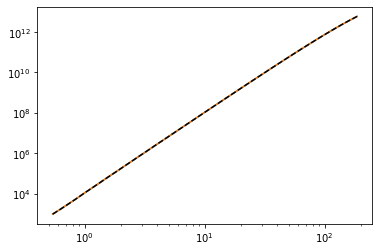

0 2 1


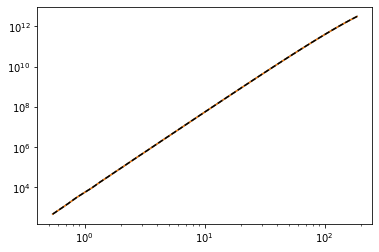

0 2 2


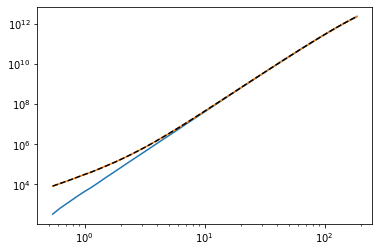

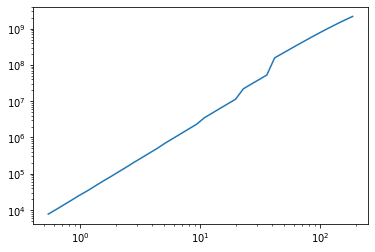

1 0 0


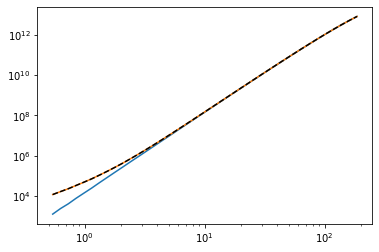

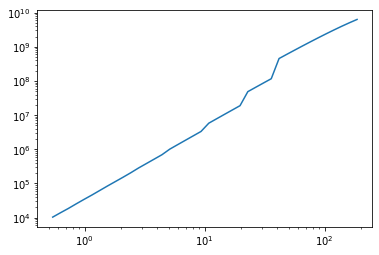

1 0 1


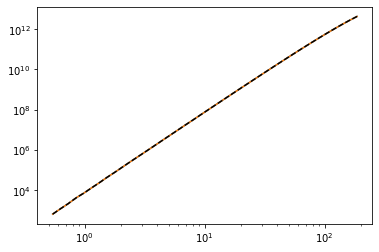

1 0 2


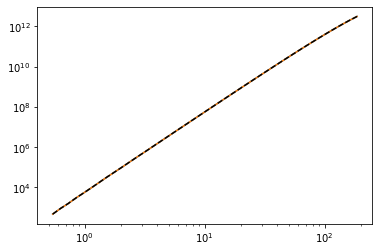

1 1 0


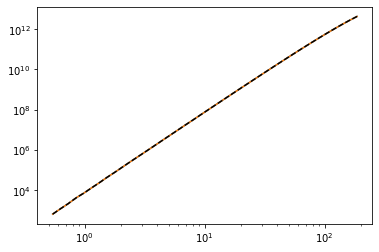

1 1 1


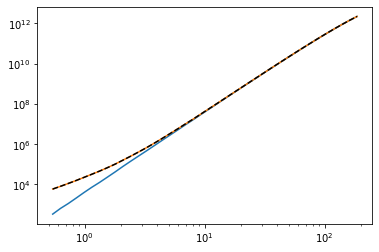

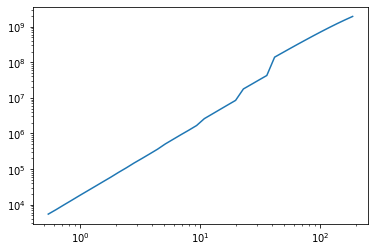

1 1 2


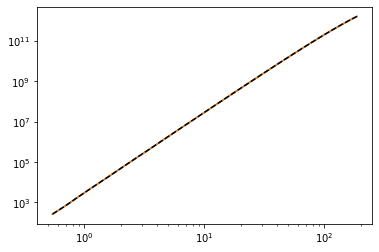

1 2 0


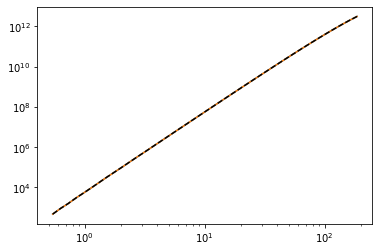

1 2 1


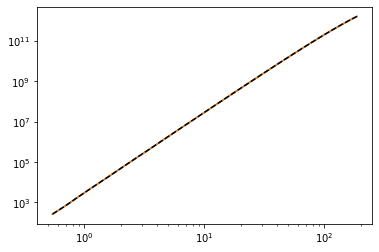

1 2 2


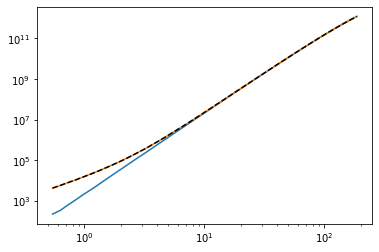

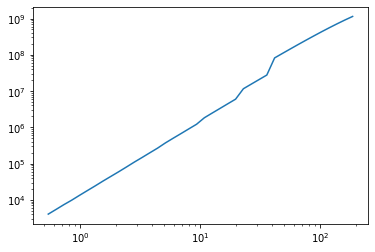

2 0 0


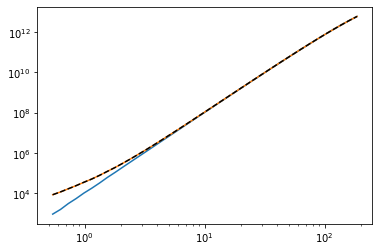

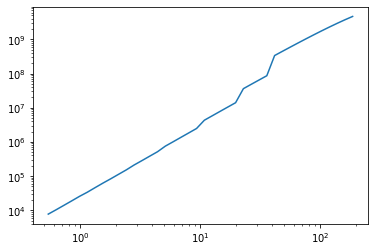

2 0 1


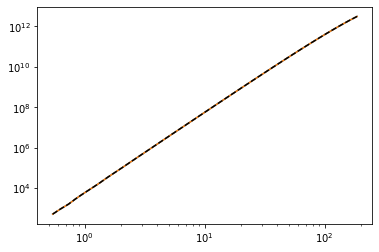

2 0 2


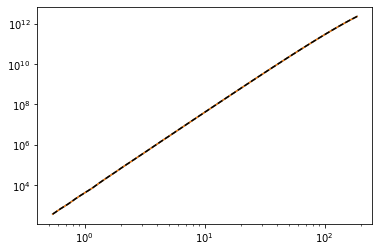

2 1 0


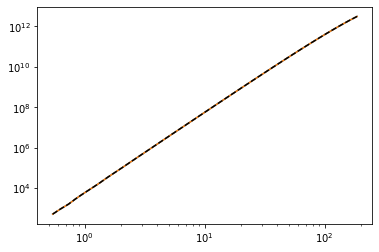

2 1 1


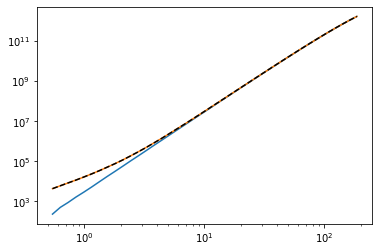

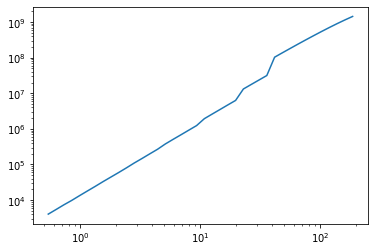

2 1 2


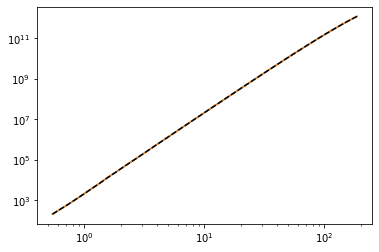

2 2 0


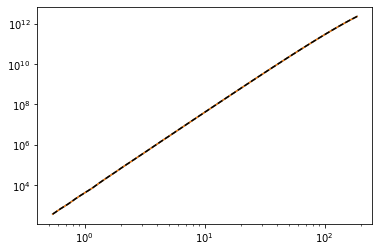

2 2 1


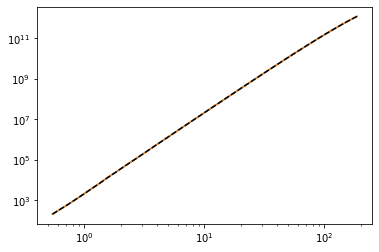

2 2 2


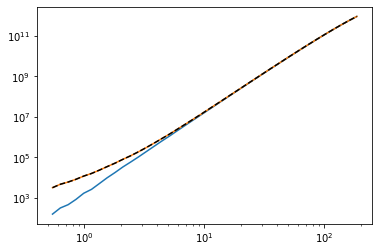

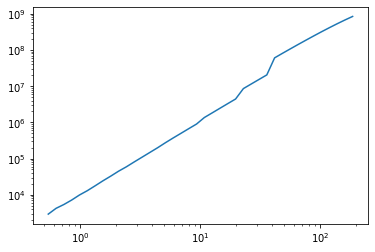

In [10]:
eln = 0
nbinsz = 3
for z1 in range(nbinsz):
    for z2 in range(nbinsz):
        for z3 in range(nbinsz):
            zcombi=z1*nbinsz*nbinsz+z2*nbinsz+z3
            elzcombi = ["000","001","010","011","100","101","110","111"]
            print(z1,z2,z3)
            #plt.imshow(np.log10(np.abs(threepcf_dtree.npcf_multipoles[0,eln,zcombi].real - threepcf_dtreenodc.npcf_multipoles[0,eln,zcombi].real)))
            #plt.colorbar()
            #plt.show()

            #plt.loglog(threepcf_dtree.bin_centers[0], np.abs(np.diag(threepcf_dtree.npcf_multipoles[0,eln,zcombi].real)))
            #plt.loglog(threepcf_dtree.bin_centers[0], np.abs(np.diag(threepcf_dtreenodc.npcf_multipoles[0,eln,zcombi].real)))
            #plt.show()
            plt.loglog(threepcf_dtree.bin_centers[0], np.diag(threepcf_dtree.npcf_multipoles_norm[eln,zcombi].real))
            plt.loglog(threepcf_dtree.bin_centers[0], np.diag(threepcf_dtreenodc.npcf_multipoles_norm[eln,zcombi].real))
            plt.loglog(threepcf_dtree.bin_centers[0], np.abs(np.diag(threepcf_dtreenodc.npcf_multipoles_norm[eln,zcombi].real)),"k--")
            plt.show()
            if z2==z3:
                #plt.loglog(threepcf_dtree.bin_centers[0], np.abs(np.diag(threepcf_dtree.npcf_multipoles_norm[eln,zcombi].real)/np.diag(threepcf_dtreenodc.npcf_multipoles_norm[eln,zcombi].real)))
                #plt.show()
                plt.loglog(threepcf_dtree.bin_centers[0], np.abs(np.diag(threepcf_dtree.npcf_multipoles_norm[eln,zcombi].real)-np.diag(threepcf_dtreenodc.npcf_multipoles_norm[eln,zcombi].real)))
                plt.show()

In [73]:
np.diag(threepcf_dtree.npcf_multipoles_norm[eln,zcombi].real)-np.diag(threepcf_dtreenodc.npcf_multipoles_norm[eln,zcombi].real)

array([-8.00830000e+04, -8.00830000e+04, -8.00830000e+04, -8.00830000e+04,
       -8.00830000e+04, -8.00830000e+04, -8.00830000e+04, -8.00830000e+04,
       -8.00830000e+04, -8.00830000e+04, -8.00830000e+04, -2.67551000e+05,
       -2.67551000e+05, -2.67551000e+05, -2.67551000e+05, -1.23608400e+06,
       -1.23608400e+06, -1.23608400e+06, -1.23608400e+06, -1.23608400e+06,
       -6.29174200e+06, -6.29174200e+06, -6.29174200e+06, -6.29174200e+06,
       -6.29174200e+06, -3.14859780e+07, -3.14859780e+07, -3.14859780e+07,
       -3.14859780e+07, -1.43597688e+09, -1.43597688e+09, -1.43597688e+09,
       -1.43597688e+09, -1.43597688e+09, -1.43597688e+09, -1.43597688e+09,
       -1.43597688e+09, -1.43597688e+09, -1.43597688e+09, -1.43597688e+09])

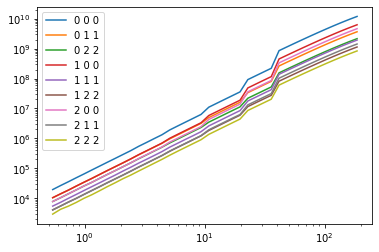

In [11]:
eln = 0
nbinsz = 3
for z1 in range(nbinsz):
    for z2 in range(nbinsz):
        for z3 in range(nbinsz):
            zcombi=z1*nbinsz*nbinsz+z2*nbinsz+z3
            if z2==z3:
                #plt.loglog(threepcf_dtree.bin_centers[0], np.abs(np.diag(threepcf_dtree.npcf_multipoles_norm[eln,zcombi].real)/np.diag(threepcf_dtreenodc.npcf_multipoles_norm[eln,zcombi].real)))
                #plt.show()
                plt.loglog(threepcf_dtree.bin_centers[0], np.abs(np.diag(threepcf_dtree.npcf_multipoles_norm[eln,zcombi].real)-np.diag(threepcf_dtreenodc.npcf_multipoles_norm[eln,zcombi].real)),label="%i %i %i"%(z1,z2,z3))
plt.legend()
plt.show()

In [90]:
gggsas_bs0p1.gam0r.shape

(40, 40, 30)

/cosma/local/pythonconda3/2020-02/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


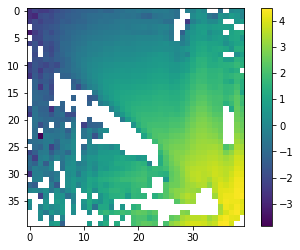

/cosma/local/pythonconda3/2020-02/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


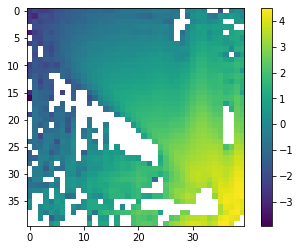

In [163]:
eln = 3

plt.imshow(np.log10(-(ggg_bsbase.gam2r[:,:,100+eln])))
plt.colorbar()
plt.show()
plt.imshow(np.log10((threepcf_dtree10.npcf_multipoles[3,eln,0].real)))
plt.colorbar()
plt.show()

/cosma/local/pythonconda3/2020-02/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


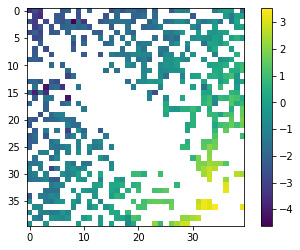

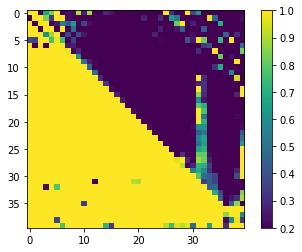

In [120]:
n = 0
plt.imshow((np.abs(threepcf_dtree20.npcf_multipoles[3,n,0].real/ggg_bs0p1.gam3r[:,:,30+n])),vmax=1,vmin=.2)
plt.colorbar()

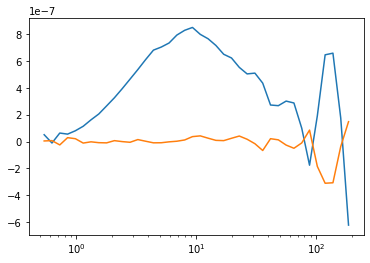

In [294]:
plt.semilogx(threepcf_dtree10.bin_centers[0],threepcf_dtree10.bin_centers[0]*np.diag(threepcf_dtree10.npcf[0,0,:,:,17].real))
plt.semilogx(threepcf_dtree10.bin_centers[0],threepcf_dtree10.bin_centers[0]*np.diag(threepcf_dtree10.npcf[0,0,:,:,17].imag))

In [326]:
threepcf_dtree10.multipoles2npcf()
threepcf_dtree10.projectnpcf("Centroid")
threepcf_dtree10.projection
threepcf_disc.multipoles2npcf()
threepcf_disc.projectnpcf("Centroid")
threepcf_disc.projection

'Centroid'

2.0843630224166705 41.68102941366865


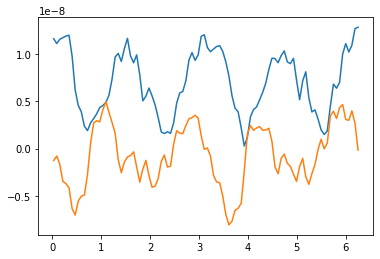

In [341]:
elcomp = 0
elb1 = 9
elb2 = 29
print(threepcf_dtree10.bin_centers_mean[elb1],threepcf_dtree10.bin_centers_mean[elb2])
plt.plot(threepcf_dtree10.phi, threepcf_dtree10.npcf[elcomp,0,elb1,elb2,:].real)
plt.plot(threepcf_dtree10.phi, threepcf_dtree10.npcf[elcomp,0,elb1,elb2,:].imag)

1.7756868589224644 34.64256168543956


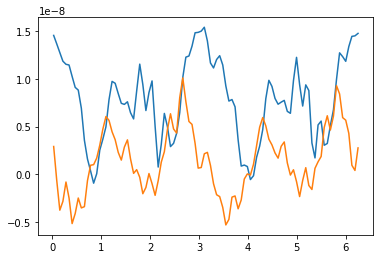

In [349]:
elcomp = 0
elb1 = 8
elb2 = 28
print(threepcf_disc.bin_centers_mean[elb1],threepcf_disc.bin_centers_mean[elb2])
plt.plot(threepcf_disc.phi, threepcf_disc.npcf[elcomp,0,elb1,elb2,:].real)
plt.plot(threepcf_disc.phi, threepcf_disc.npcf[elcomp,0,elb1,elb2,:].imag)

In [23]:
import pickle

In [24]:
with open("/cosma7/data/dp004/dc-port3/Analysis/NPOINTFFT/SLICS/KiDS450_Unmasked_NoPatches_Noiseless_0p3125_160p0_growth1p05_nmax20/resultggg_1.pickle", "rb") as input_file:
    singledata = pickle.load(input_file)
with open("/cosma7/data/dp004/dc-port3/Analysis/NPOINTFFT/SLICS/KiDS450_Unmasked_NoPatches_Noiseless_0p3125_160p0_growth1p05_nmax20/reduceddata/quickGammaSummaries.pickle", "rb") as input_file:
    ensdata = pickle.load(input_file)

In [25]:
map3s_dpix = threepcf_dtree.computeMap3(radii=singledata['Map3']["Fine"]['R'], do_multiscale=False, tofile=False, filtercache=None)

/cosma/local/pythonconda3/2020-02/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


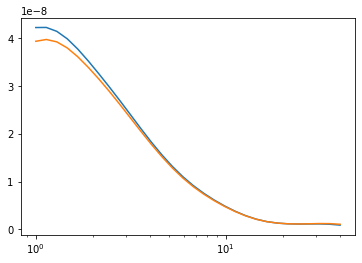

/cosma/local/pythonconda3/2020-02/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


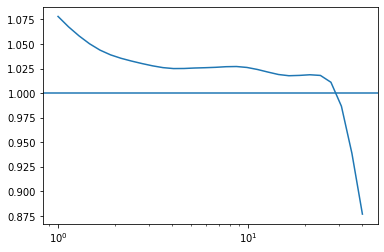

In [29]:
plt.semilogx(singledata['Map3']["Fine"]['R'], singledata['Map3']["Fine"]['Map3_ec'][0,0])
#plt.errorbar(x=ensdata["radii"], y=np.mean(ensdata['Map3s'][:,0,0],axis=0), yerr=np.std(ensdata['Map3s'][:,0,0],axis=0))
plt.semilogx(singledata['Map3']["Fine"]['R'], map3s_dpix[0,0])
plt.show()

plt.semilogx(singledata['Map3']["Fine"]['R'], singledata['Map3']["Fine"]['Map3'][0,0]/map3s_dpix15[0,0])
plt.axhline(1)

In [38]:
mmap3s_dpix = threepcf_dtree.computeMap3(radii=[1,2,4,8,16], do_multiscale=True, tofile=False, filtercache=None)

/cosma/local/pythonconda3/2020-02/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(8, 1, 125)

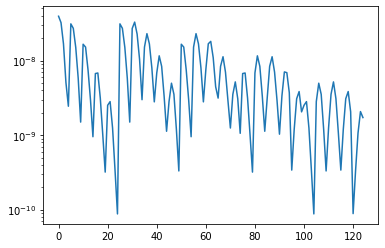

In [40]:
plt.semilogy(mmap3s_dpix[0,0])
mmap3s_dpix.shape

In [388]:
olddata.keys()

dict_keys(['times', 'Multipoles_mean_noec', 'Multipoles_mean', 'Gamma_std', 'Map3s', 'phis', 'Map3smulti', 'Map3s_noec', 'Multipoles_std', 'Gamma_mean_noec', 'centers', 'Gamma_mean', 'Map3smulti_noec', 'pars', 'radii', 'edges'])

In [393]:
olddata["radii"]

array([ 0.25      ,  0.28050461,  0.31473135,  0.35313439,  0.3962233 ,
        0.44456985,  0.49881558,  0.55968028,  0.62797161,  0.70459573,
        0.79056942,  0.88703347,  0.99526793,  1.11670898,  1.25296808,
        1.40585331,  1.57739336,  1.76986446,  1.98582059,  2.22812735,
        2.5       ,  2.80504614,  3.14731353,  3.53134386,  3.96223298,
        4.44569853,  4.98815579,  5.59680285,  6.27971608,  7.04595733,
        7.90569415,  8.87033473,  9.95267926, 11.1670898 , 12.52968084,
       14.05853313, 15.77393361, 17.69864461, 19.85820587, 22.28127345,
       25.        ])

In [42]:
ensdata.keys()

dict_keys(['times', 'Multipoles_mean_noec', 'Multipoles_mean', 'Gamma_std', 'Map3s', 'phis', 'Map3smulti', 'Map3s_noec', 'Multipoles_std', 'Gamma_mean_noec', 'centers', 'Gamma_mean', 'Map3smulti_noec', 'pars', 'radii', 'edges'])

In [ ]:
singledata.keys()

In [62]:
with open("/cosma7/data/dp004/dc-port3/Analysis/ApertureMass/SLICS/KiDS450_CroppedUnmasked_Noiseless_FixedR_InvShot_C02_Acc1p0/results_batched.pickle", "rb") as input_file:
    dirdata = pickle.load(input_file)

In [66]:
dirdata["result_1.pickle"]['Pars']['radii']

array([ 0.25      ,  0.2914786 ,  0.3398391 ,  0.3962233 ,  0.46196245,
        0.53860867,  0.62797161,  0.73216114,  0.85363722,  0.99526793,
        1.16039721,  1.35292382,  1.57739336,  1.83910564,  2.14423975,
        2.5       ,  2.914786  ,  3.39839098,  3.96223298,  4.61962449,
        5.38608673,  6.27971608,  7.32161141,  8.53637218,  9.95267926,
       11.60397208, 13.52923816, 15.77393361, 18.39105636, 21.44239746,
       25.        ])

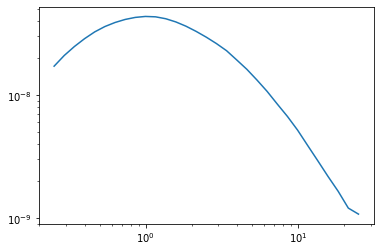

In [64]:
plt.loglog(dirdata["result_1.pickle"]['Pars']['radii'], dirdata["result_1.pickle"]['Meas']["Map_3"][0])

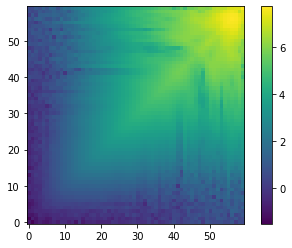

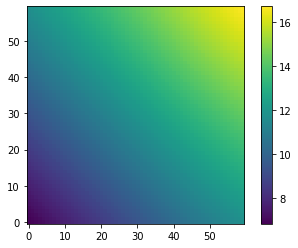

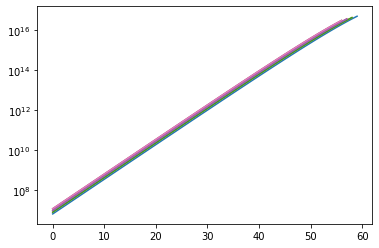

In [229]:
elcomp = 0
elzcombi = 0
eln = 0
plt.imshow(np.log10(np.abs(threepcf_dtree.npcf_multipoles[elcomp,eln,elzcombi])), origin="lower")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi])), origin="lower")
plt.colorbar()
plt.show()

plt.semilogy(np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi])))
plt.semilogy(np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]), k=1))
plt.semilogy(np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]), k=-1))
plt.semilogy(np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]), k=2))
plt.semilogy(np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]), k=-2))
plt.semilogy(np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]), k=3))
plt.semilogy(np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]), k=-3))

In [230]:
rindmax = np.argwhere(threepcf_dtree.bin_edges[1:]<threepcf_dtree.tree_redges[1])[-1][0]
maindiag = np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi])[:rindmax])
super1 = np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]),k=1)[:rindmax-1]
super2 = np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]),k=2)[:rindmax-2]
ratio_m1 = np.sum(maindiag[1:])/np.sum(super1)
ratio_s1s2 = np.sum(super1[1:])/np.sum(super2)
print(ratio_m1,ratio_s1s2)
modified_super1 = ratio_s1s2*np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]),k=2)[rindmax-2:]
modified_main = ratio_m1*modified_super1
renormed_main = np.append(maindiag, modified_main)
renormed_super = np.append(super1, modified_super1)


1.2202950022440653 1.2205443075384605


(0.8, 1.2)

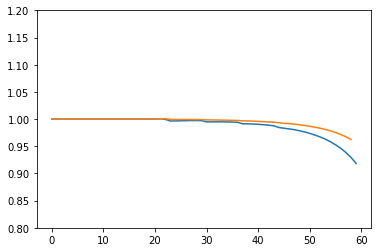

In [231]:
#plt.semilogy(np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi])))
#plt.semilogy(np.abs(np.append(maindiag, modified_main)))
plt.plot(np.abs(np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]))/renormed_main))

#plt.semilogy(np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]),k=1))
#plt.semilogy(np.abs(np.append(super1, modified_super1)))
plt.plot(np.abs(np.diag(np.abs(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]),k=1)/renormed_super))
plt.ylim(0.8,1.2)

In [232]:
import copy

In [559]:
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols
    
thisnorm = copy.deepcopy(threepcf_dtree.npcf_multipoles_norm)
for elz in range(thisnorm.shape[1]):
    for eln in range(1,thisnorm.shape[0]):
        if eln==1 and elz==0:
            thisrows, thiscols = kth_diag_indices(thisnorm[eln,elz], k=0)
            thisrowsp, thiscolsp = kth_diag_indices(thisnorm[eln,elz], k=1)
            thisrowsm, thiscolsm = kth_diag_indices(thisnorm[eln,elz], k=-1)
            
        rindmax = np.argwhere(threepcf_dtree.bin_edges[1:]<threepcf_dtree.tree_redges[1])[-1][0]-2
        
        # Real part
        maindiag = np.diag(np.real(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi])[:rindmax])
        super1 = np.diag(np.real(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]),k=1)[:rindmax-1]
        super2 = np.diag(np.real(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]),k=2)[:rindmax-2]
        ratio_m1 = np.sum(maindiag[1:])/np.sum(super1)
        ratio_s1s2 = np.sum(super1[1:])/np.sum(super2)
        #print(ratio_m1,ratio_s1s2)
        modified_super1 = ratio_s1s2*np.diag(np.real(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]),k=2)[rindmax-2:]
        modified_main = ratio_m1*modified_super1
        renormed_main_re = np.append(maindiag, modified_main)
        renormed_super_re = np.append(super1, modified_super1)
        
        # Imaag part
        maindiag = np.diag(np.imag(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi])[:rindmax])
        super1 = np.diag(np.imag(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]),k=1)[:rindmax-1]
        super2 = np.diag(np.imag(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]),k=2)[:rindmax-2]
        ratios_m1 = np.abs(np.sum(maindiag[1:])/np.sum(super1))
        ratio_m1 = np.abs(np.sum(maindiag[1:])/np.sum(super1))
        ratio_s1s2 = np.abs(np.sum(super1[1:])/np.sum(super2))
        print(ratio_m1,ratio_s1s2)
        modified_super1 = ratio_s1s2*np.diag(np.imag(threepcf_dtree.npcf_multipoles_norm[eln,elzcombi]),k=2)[rindmax-2:]
        modified_main = ratio_m1*modified_super1
        renormed_main_im = np.append(maindiag, modified_main)
        renormed_super_im = np.append(super1, modified_super1)

        thisnorm[eln,elz][thisrows,thiscols] = renormed_main_re + 1J*renormed_main_im
        thisnorm[eln,elz][thisrowsp,thiscolsp] = renormed_super_re + 1J*renormed_super_im
        thisnorm[eln,elz][thisrowsm,thiscolsm] = renormed_super_re + 1J*renormed_super_im
#np.diag(np.ab(thisnorm[1:,:]),k=1) = modified_super1

0.0 1.3215733066614814
0.0 1.5733606998089706
0.0 1.4391322762159497
0.0 9.581305258963537
0.0 13.73150673682858
0.0 0.2671731778851854
0.0 4.326300953268323
0.0 0.22349794292676373
0.0 6.443205369859515
0.0 1.34268523737119
0.0 6.26483265105479
0.0 0.27296073806625654
0.0 0.5215579072501999
0.0 1.2218284793682501
0.0 0.6986583852146631
0.0 0.163423990251944
0.0 14.565710864996829
0.0 0.41984193383030155
0.0 1.913551872889285
0.0 2.9292422839535694
0.0 2.4442441605319676
0.0 0.6097432299027907
0.0 1.1812922095471534
0.0 4.626535896841456
0.0 7.448180899072658
0.0 0.6509637364331987
0.0 20.69614478176855
0.0 0.07398306617128209
0.0 0.43437882859906213
0.0 9.232208054665453


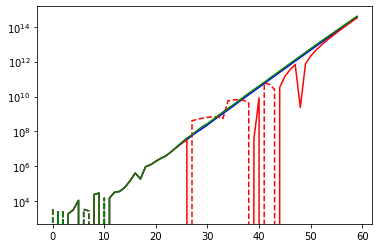

Text(0.5, 1.0, 'Diagonal renormalization for n=4, k=0')

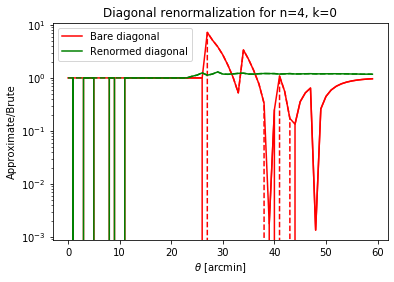

In [589]:
thisn = 4
thisk = 0
thisbase = np.diag(np.real(threepcf_dtree.npcf_multipoles_norm[thisn,elzcombi]),k=thisk)
thisrenorm = np.diag(np.real(thisnorm[thisn,elzcombi]),k=thisk)
thisbrute = np.diag(np.real(tcxbrute.weightr[:,:,30+thisn] + 1j*tcxbrute.weighti[:,:,30+thisn]), k=thisk)


plt.semilogy(thisbrute, "b-" )
plt.semilogy(-thisbrute, "b--" )
plt.semilogy(thisbase, "r-")
plt.semilogy(-thisbase, "r--")
plt.semilogy(thisrenorm, "g-")
plt.semilogy(-thisrenorm, "g--")
plt.show()

plt.semilogy(np.abs(thisbase)/thisbrute, "r-", label="Bare diagonal")
plt.semilogy(thisbase/thisbrute, "r-")
plt.semilogy(-thisbase/thisbrute, "r--")
plt.semilogy(np.abs(thisrenorm)/thisbrute, "g-", label="Renormed diagonal")
plt.semilogy(thisrenorm/thisbrute, "g--")
plt.semilogy(-thisrenorm/thisbrute, "g:")
plt.legend()
plt.xlabel(r"$\theta$ [arcmin]")
plt.ylabel("Approximate/Brute")
plt.title("Diagonal renormalization for n=%i, k=%i"%(thisn, thisk))


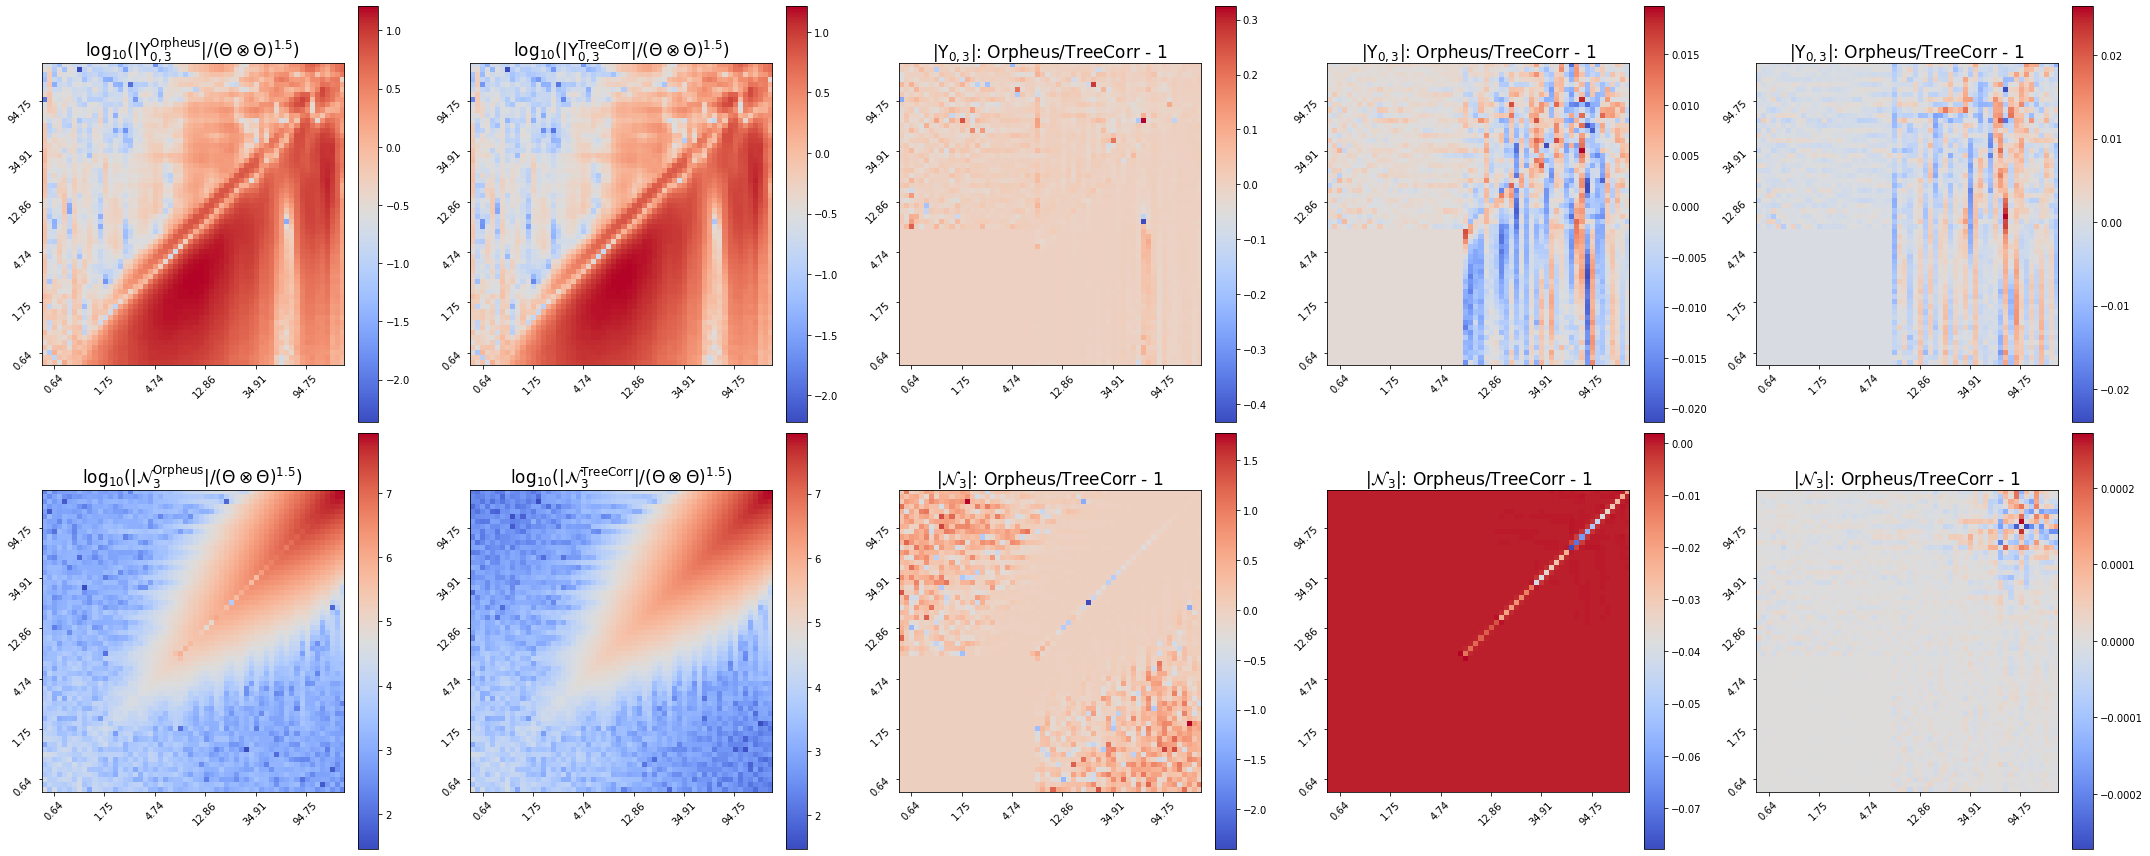

In [492]:
nzero = 30
thisn = 3
elzcombi = 0
elcomp = 0

thisbincenters = orpheus30["bin_centers"] # Orpheus centers
binnorm = np.outer(thisbincenters,thisbincenters) 
mor = orpheus30["Multipoles"][elcomp,thisn,elzcombi]/binnorm**1.5
mtc = tcUpsilon[elcomp][:,:,30+thisn]/binnorm**1.5
nor = orpheus30["Multipoles_norm"][thisn,elzcombi]/binnorm**1.5
ntc = tcNorm[:,:,30+thisn]/binnorm**1.5

# Plot Mean of Upsilon_n and N_n
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(30, 12), constrained_layout=False)
titles = [
    r'$\log_{10}(|\Upsilon^{\rm Orpheus}_{%i,%i}|/(\Theta \otimes \Theta)^{1.5})$' % (elcomp, thisn),
    r'$\log_{10}(|\Upsilon^{\rm TreeCorr}_{%i,%i}|/(\Theta \otimes \Theta)^{1.5})$' % (elcomp, thisn),
    r'$|\Upsilon_{%i,%i}|$: Orpheus/TreeCorr - 1' % (elcomp, thisn),
    r'$|\Upsilon_{%i,%i}|$: Orpheus/TreeCorr - 1' % (elcomp, thisn),
    r'$|\Upsilon_{%i,%i}|$: Orpheus/TreeCorr - 1' % (elcomp, thisn),
    r'$\log_{10}(|\mathcal{N}^{\rm Orpheus}_{%i}|/(\Theta \otimes \Theta)^{1.5})$' % thisn,
    r'$\log_{10}(|\mathcal{N}^{\rm TreeCorr}_{%i}|/(\Theta \otimes \Theta)^{1.5})$' % thisn,
    r'$|\mathcal{N}_{%i}|$: Orpheus/TreeCorr - 1' % thisn,
    r'$|\mathcal{N}_{%i}|$: Orpheus/TreeCorr - 1' % thisn,
    r'$|\mathcal{N}_{%i}|$: Orpheus/TreeCorr - 1' % thisn,
]
data_list = [
    np.log10(np.abs(mor)),
    np.log10(np.abs(mtc)),
    np.log10(np.abs(mor)/np.abs(mtc)),
    np.real(mor+mtc)/np.abs(np.max(mtc)),
    np.imag(mor+mtc)/np.abs(np.max(mtc)),
    np.log10(np.abs(nor)),
    np.log10(np.abs(ntc)),
    np.log10(np.abs(nor)/np.abs(ntc)),
    np.real(nor-ntc)/np.abs(np.max(ntc)),
    np.imag(nor-ntc)/np.abs(np.max(ntc)),
]
vmin_vmax = [(None, None) for _ in range(10)]
vmin_vmax[2] = (None, None)  
vmin_vmax[5] = (None, None) 
x = np.exp(np.linspace(np.log(0.5), np.log(200), 60+1))
for ax, data, title, (vmin, vmax) in zip(axs.flat, data_list, titles, vmin_vmax):
    im = ax.imshow(data, interpolation=None, cmap='coolwarm', vmin=vmin, vmax=vmax, origin="lower")
    #fig.colorbar(im, ax=ax)
    cbar = fig.colorbar(im, ax=ax, fraction=0.1, pad=0.04)
    ax.set_title(title, fontsize=17)
    ax.set_xticks(np.arange(len(thisbincenters))[2::10])
    ax.set_yticks(np.arange(len(thisbincenters))[2::10])
    ax.set_xticklabels(['{:.2f}'.format(i) for i in thisbincenters[2::10]], rotation=45)
    ax.set_yticklabels(['{:.2f}'.format(i) for i in thisbincenters[2::10]], rotation=45)
    
fig.subplots_adjust(top=1)
fig.tight_layout()
plt.show()


In [352]:
import treecorr
import fitsio

In [487]:
tcfile = "/cosma7/data/dp004/dc-port3/Analysis/NPOINTFFT/OrpheusTest/TreeCorrCompare/LOS1_ggg_bs0.fits"
tcxbrute=treecorr.GGGCorrelation(min_sep=0.5, max_sep=200., nbins=60, max_n=30, bin_type="LogMultipole")
tcxbrute.read(tcfile)

tcUpsilon = [tcxbrute.gam0, tcxbrute.gam1, tcxbrute.gam3, tcxbrute.gam2]
tcNorm = tcxbrute.weight

orpheus30 = pickle_load(savepath30)

In [484]:
from astropy.table import Table

def pickle_save(data, fname):
    with open(fname, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def pickle_load(fname):
    with open(fname, 'rb') as handle:
        res = pickle.load(handle)
    return res

In [486]:
savepath30 = "/cosma7/data/dp004/dc-port3/Analysis/NPOINTFFT/OrpheusTest/TreeCorrCompare/LOS1_ggg_d30.fits"
result = {}
result["Pars"] = {}
result["Pars"]["min_sep"] = threepcf_dtree.min_sep
result["Pars"]["max_sep"] = threepcf_dtree.max_sep
result["Pars"]["binsize"] = threepcf_dtree.binsize
result["Pars"]["nbinsr"] = threepcf_dtree.nbinsr
result["Pars"]["rmin_pixsize"] = threepcf_dtree.rmin_pixsize
result["Pars"]["dpixs"] = threepcf_dtree.tree_resos
result["Pars"]["method"] = threepcf_dtree.method
result["Pars"]["nthreads"] = 16
result["Pars"]["time"] = 16.5*60
result["Pars"]["dotomo"] = False
result["Pars"]["cat"] = "/cosma7/data/dp004/dc-port3/Data/SLICS/KiDS450/GalCatalog_LOS1.fits"
result["Multipoles"] = threepcf_dtree.npcf_multipoles
result["Multipoles_norm"] = threepcf_dtree.npcf_multipoles_norm
result["bin_centers"] = threepcf_dtree.bin_centers_mean

pickle_save(result, savepath)

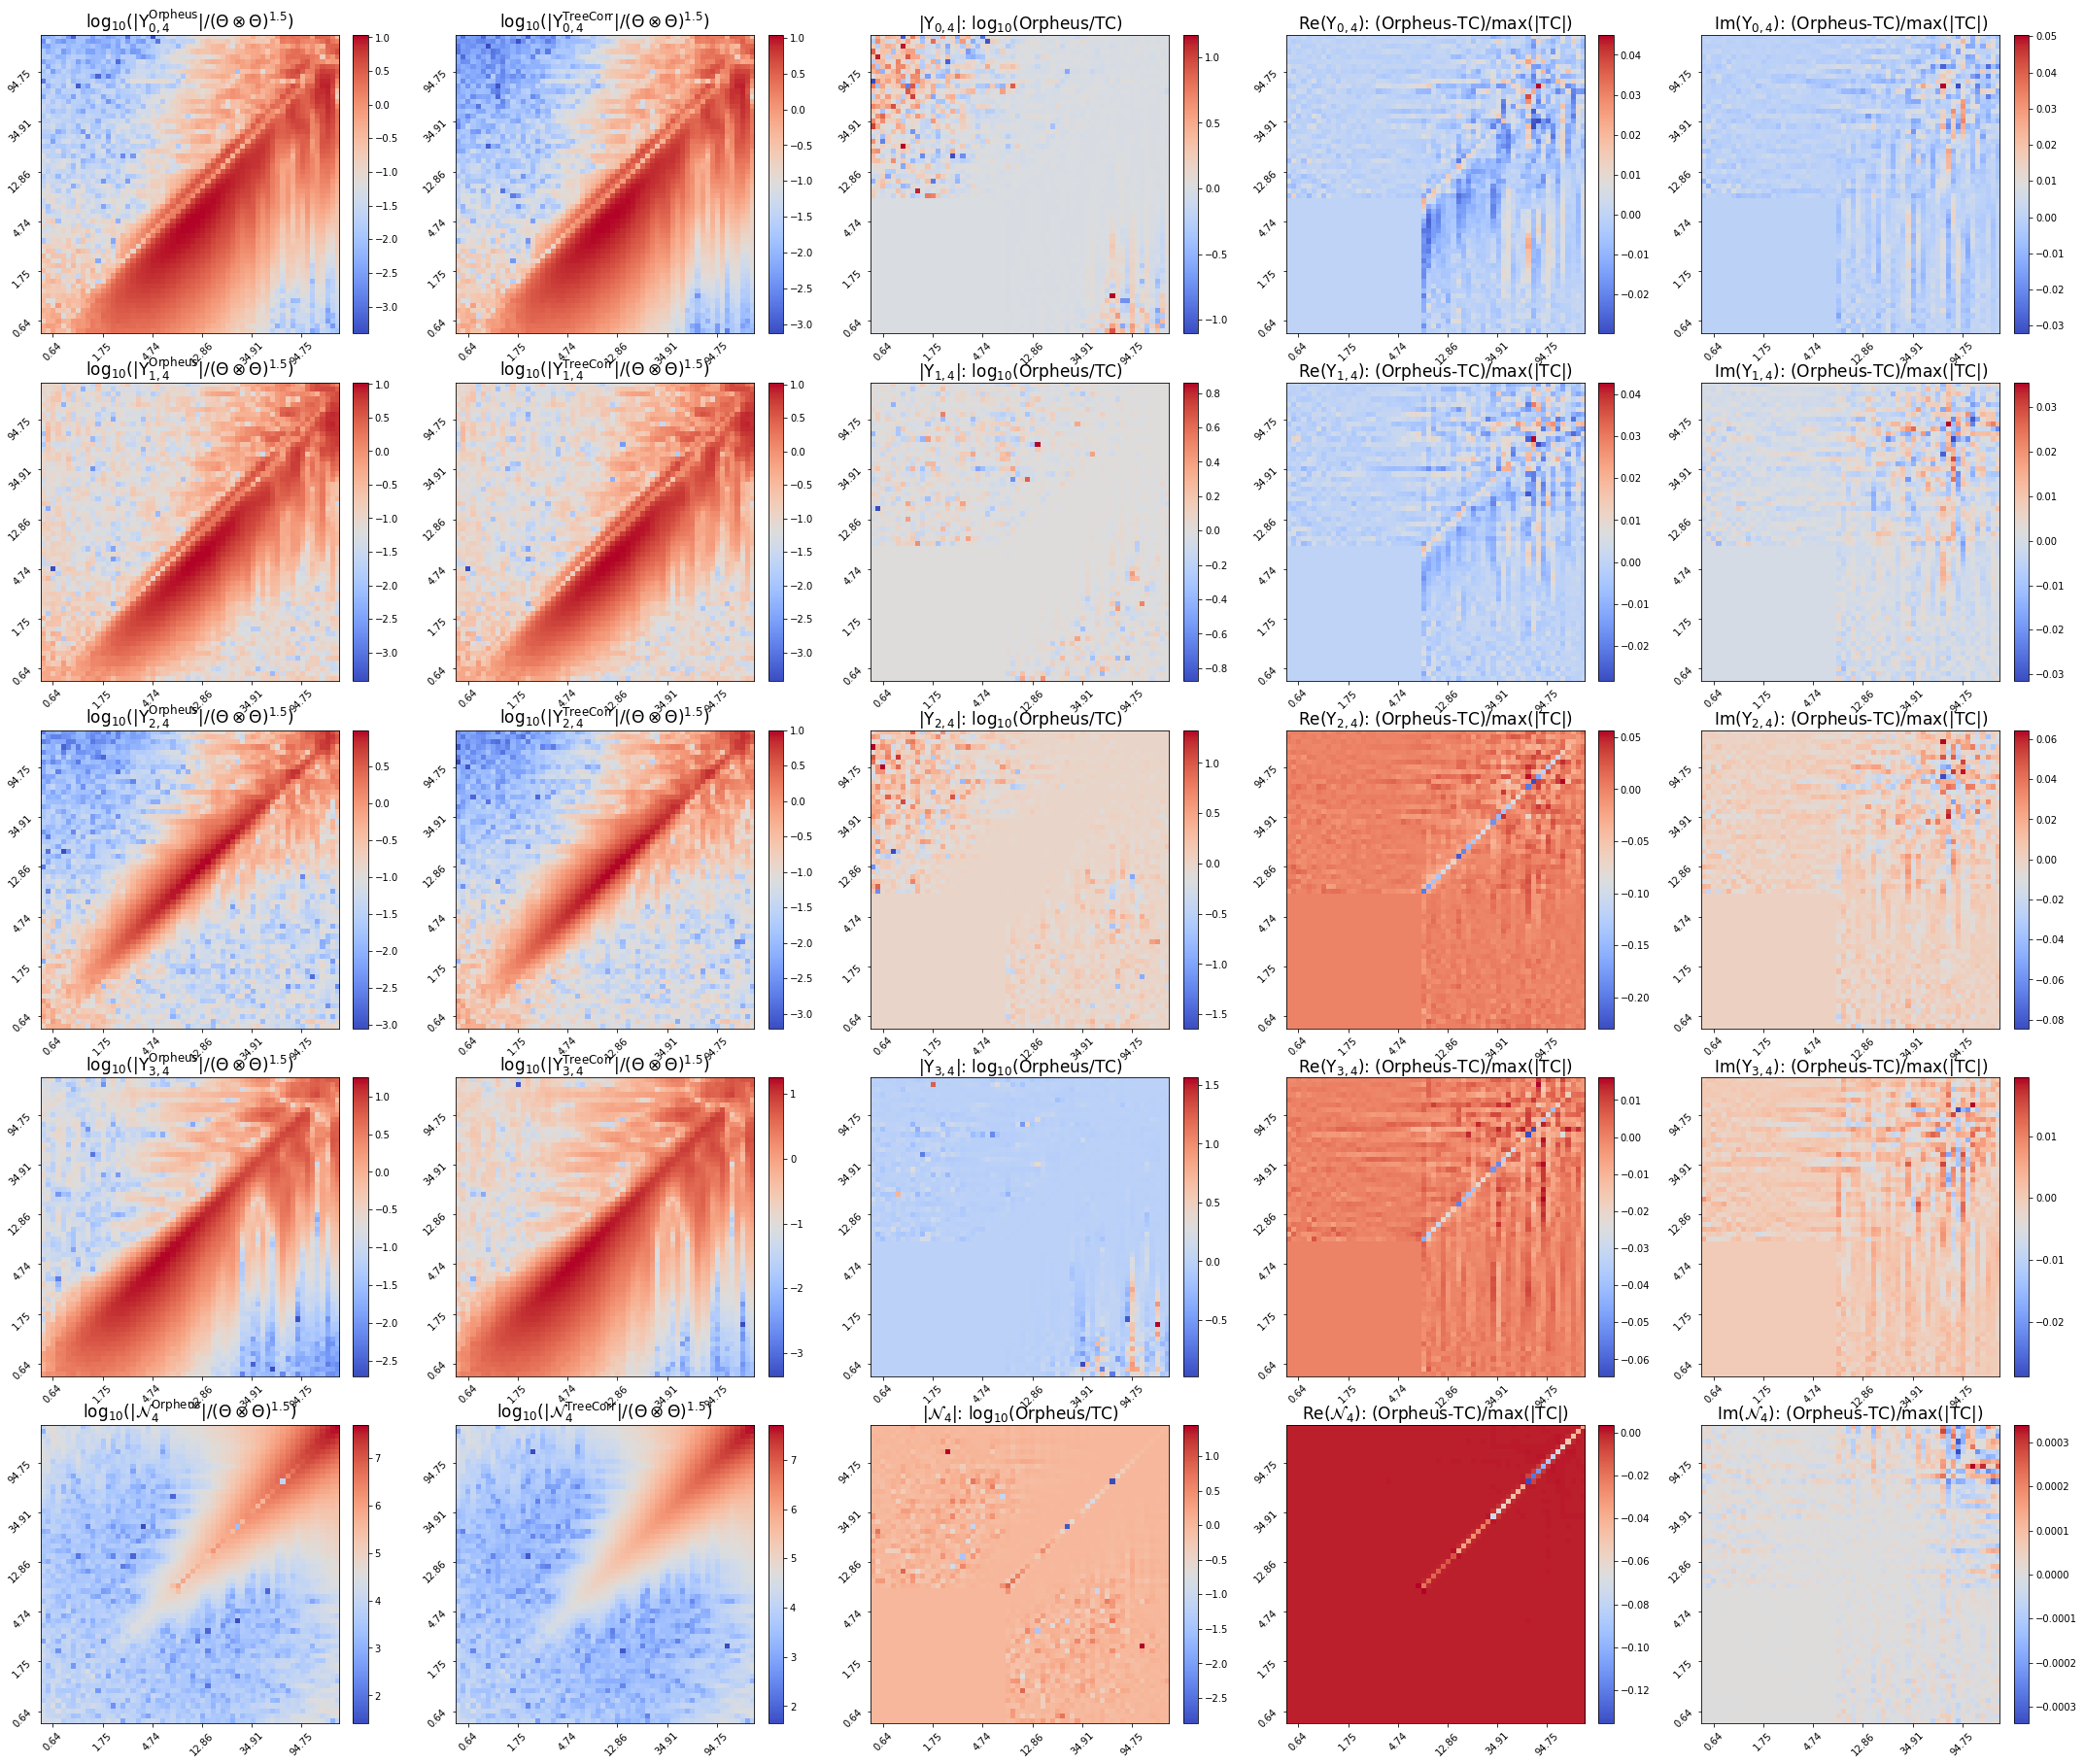

In [495]:
nzero = 30
thisn = 4
elzcombi = 0

thisbincenters = orpheus30["bin_centers"] # Orpheus centers
binnorm = np.outer(thisbincenters,thisbincenters) 

# Plot Mean of Upsilon_n and N_n
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(30, 25), constrained_layout=False)
for elcomp in range(4):
    mor = orpheus30["Multipoles"][elcomp,thisn,elzcombi]/binnorm**1.5
    mtc = tcUpsilon[elcomp][:,:,30+thisn]/binnorm**1.5
    data_list = [
        np.log10(np.abs(mor)),
        np.log10(np.abs(mtc)),
        np.log10(np.abs(mor)/np.abs(mtc)),
        np.real(mor+mtc)/np.abs(np.max(mtc)),
        np.imag(mor+mtc)/np.abs(np.max(mtc)),]
    titles = [
        r'$\log_{10}(|\Upsilon^{\rm Orpheus}_{%i,%i}|/(\Theta \otimes \Theta)^{1.5})$' % (elcomp, thisn),
        r'$\log_{10}(|\Upsilon^{\rm TreeCorr}_{%i,%i}|/(\Theta \otimes \Theta)^{1.5})$' % (elcomp, thisn),
        r'$|\Upsilon_{%i,%i}|$: $\log_{10}$(Orpheus/TC)' % (elcomp, thisn),
        r'${\rm Re}(\Upsilon_{%i,%i})$: (Orpheus-TC)/max(|TC|)' % (elcomp, thisn),
        r'${\rm Im}(\Upsilon_{%i,%i})$: (Orpheus-TC)/max(|TC|)' % (elcomp, thisn),]

    for elcol in range(5):
        thisax = axs[elcomp,elcol]
        im = thisax.imshow(data_list[elcol], interpolation=None, cmap='coolwarm', origin="lower")
        cbar = fig.colorbar(im, ax=thisax, fraction=0.1, pad=0.04)
        thisax.set_title(titles[elcol], fontsize=17)
        thisax.set_xticks(np.arange(len(thisbincenters))[2::10])
        thisax.set_yticks(np.arange(len(thisbincenters))[2::10])
        thisax.set_xticklabels(['{:.2f}'.format(i) for i in thisbincenters[2::10]], rotation=45)
        thisax.set_yticklabels(['{:.2f}'.format(i) for i in thisbincenters[2::10]], rotation=45) 
nor = orpheus30["Multipoles_norm"][thisn,elzcombi]/binnorm**1.5
ntc = tcNorm[:,:,30+thisn]/binnorm**1.5
data_list = [
    np.log10(np.abs(nor)),
    np.log10(np.abs(ntc)),
    np.log10(np.abs(nor)/np.abs(ntc)),
    np.real(nor-ntc)/np.abs(np.max(ntc)),
    np.imag(nor-ntc)/np.abs(np.max(ntc)),]
titles = [
    r'$\log_{10}(|\mathcal{N}^{\rm Orpheus}_{%i}|/(\Theta \otimes \Theta)^{1.5})$' % thisn,
    r'$\log_{10}(|\mathcal{N}^{\rm TreeCorr}_{%i}|/(\Theta \otimes \Theta)^{1.5})$' % thisn,
    r'$|\mathcal{N}_{%i}|$: $\log_{10}$(Orpheus/TC)' % thisn,
    r'${\rm Re}(\mathcal{N}_{%i})$: (Orpheus-TC)/max(|TC|)' % thisn,
    r'${\rm Im}(\mathcal{N}_{%i})$: (Orpheus-TC)/max(|TC|)' % thisn,]

for elcol in range(5):
    thisax = axs[-1,elcol]
    im = thisax.imshow(data_list[elcol], interpolation=None, cmap='coolwarm', origin="lower")
    cbar = fig.colorbar(im, ax=thisax, fraction=0.1, pad=0.04)
    thisax.set_title(titles[elcol], fontsize=17)
    thisax.set_xticks(np.arange(len(thisbincenters))[2::10])
    thisax.set_yticks(np.arange(len(thisbincenters))[2::10])
    thisax.set_xticklabels(['{:.2f}'.format(i) for i in thisbincenters[2::10]], rotation=45)
    thisax.set_yticklabels(['{:.2f}'.format(i) for i in thisbincenters[2::10]], rotation=45)
    
fig.subplots_adjust(top=1)
fig.tight_layout()
plt.show()

In [620]:
pwd

'/cosma/home/dp004/dc-port3/Projects/ToGithub/Orpheus/Tutorials_private'

In [576]:
maindiag[1:]#/super1*1e10

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [622]:
%%time
threepcf_dtree.multipoles2npcf()

CPU times: user 38.8 s, sys: 233 ms, total: 39 s
Wall time: 39.1 s


In [602]:
import numpy as np

def _multipoles2npcf(inst):
    inv2pi = 1. / (2 * np.pi)
    _, nzcombis, rbins, _ = inst.npcf_multipoles[0].shape
    phi_len = len(inst.phi)
    # Initialize npcfs with the correct shape to accommodate phi_len in the last dimension
    inst.npcf = np.zeros((4, nzcombis, rbins, rbins, phi_len), dtype=complex)
    inst.npcf_norm = np.zeros((nzcombis, rbins, rbins, phi_len), dtype=complex)

    # Prepare N0 and exponential for broadcasting
    N0 = inv2pi * inst.npcf_multipoles_norm[0].astype(complex).reshape((1, nzcombis, rbins, rbins, 1))
    _phis = np.exp(1J * np.arange(1, inst.nmax + 1)[:, None] * inst.phi[None, :]).astype(complex)
    _phis = _phis.reshape((inst.nmax, 1, 1, 1, phi_len))  

    # Compute Gamma_mu
    conjmap = [0, 1, 3, 2]
    for elm in range(4):
        # Initialize tmp with the same shape as inst.npcf for direct accumulation
        ups = np.zeros_like(inst.npcf[elm])
        ups += (1. / (2 * np.pi)) * inst.npcf_multipoles[elm, 0].astype(complex)[..., None]  
        for n in range(1, inst.nmax + 1):
            phis_n = _phis[n-1]  
            ups += phis_n * inst.npcf_multipoles[elm, n].astype(complex)[..., None]
            ups += phis_n.conj() * inst.npcf_multipoles[conjmap[elm], n].astype(complex).transpose(0, 2, 1)[..., None]
        inst.npcf[elm] = ups / N0.real

    # Compute norm
    tmptotnorm = np.zeros_like(inst.npcf_norm)
    tmptotnorm += (1. / (2 * np.pi)) * inst.npcf_multipoles_norm[0].astype(complex)[..., None]  # Adjust for broadcasting
    for n in range(1, inst.nmax + 1):
        phis_n = _phis[n-1]  # Correct shape for broadcasting
        tmptotnorm += phis_n * inst.npcf_multipoles_norm[n].astype(complex)[..., None]
        tmptotnorm += phis_n.conj() * inst.npcf_multipoles_norm[n].astype(complex).transpose(0, 2, 1)[..., None]
    inst.npcf_norm = tmptotnorm

    inst.projection = "X"


In [621]:
%%time
_multipoles2npcf(threepcf_dtree)

CPU times: user 26.2 s, sys: 10.3 s, total: 36.5 s
Wall time: 36.6 s


In [623]:
float atan_approx(float z)
{
    const float n1 = 0.97239411f;
    const float n2 = -0.19194795f;
    return (n1 + n2 * z * z) * z;
}

double atan2_approx(double y, double x){
    float ay = fabs((float)y), ax = fabs((float) x);
    int invert = ay > ax;
    float z = invert ? ax/ay : ay/ax; // [0,1]
    float th = atan_approx(z);        // [0,π/4]
    if(invert) th = M_PI+M_PI - th;       // [0,π/2]
    if(x < 0) th = M_PI - th;          // [0,π]
    th = copysign(th, y);              // [-π,π]
    return (double) th;
}

SyntaxError: invalid syntax (<ipython-input-623-9b9dd89c6e76>, line 1)

In [905]:
def atan_approx(z):
    n1 = 0.97239411
    n2 = -0.19194795
    res = (n1 + n2 * z * z) * z
    #res[z<0] = -res[z<0]
    return res
def atan2_approx(y, x):
    ay = np.asarray(np.abs(y))
    ax = np.asarray(np.abs(x))
    invert = ay > ax;
    z = ay/ax
    z[invert] = 1./z[invert]
    th = atan_approx(z)
    #th[(x>0)&(y>0)] = th[(x>0)&(y>0)]
    #th[(x<0)&(y>0)] = th[(x<0)&(y>0)]+np.pi
    th[invert] = np.pi/2.-th[invert]
    th[x<0] = np.pi-th[x<0]
    th = th*np.sign(y)
    th[y<0] = 2*np.pi+th[y<0]
    return th
    
def ln_approx4a(x):
    # Ensure x is a numpy array for element-wise operations
    x = np.array(x, dtype=np.float32)
    
    # Convert float32 array to uint32 for bit manipulation
    bx = x.view(np.uint32)
    
    ex = bx >> 23
    t = (ex - 127).astype(np.int32)
    
    bx = 1065353216 | (bx & 8388607)
    
    # Convert uint32 back to float32
    x = bx.view(np.float32)
    
    result = -1.7417939 + (2.8212026 + (-1.4699568 + (0.44717955 - 0.056570851 * x) * x) * x) * x + 0.6931471806 * t
    return result

def ln_approx4b(x):
    return -1.7417939 + (2.8212026 + (-1.4699568 + (0.44717955 - 0.056570851 * x) * x) * x) * x;

import struct

import numpy as np
import struct

def ln_approx3a(x):
    # Ensure x is a numpy array for element-wise operations
    x = np.array(x, dtype=np.float32)
    
    # Convert float32 array to uint32 for bit manipulation
    bx = x.view(np.uint32)
    
    ex = bx >> 23
    t = (ex - 127).astype(np.int32)
    
    bx = 1065353216 | (bx & 8388607)
    
    # Convert uint32 back to float32
    x = bx.view(np.float32)
    
    result = -1.49278 + (2.11263 + (-0.729104 + 0.10969 * x) * x) * x + 0.6931471806 * t
    return result

def ln_approx3b(x):
    return -1.49278+(2.11263+(-0.729104+0.10969*x)*x)*x

In [906]:
xlim = 10
x = np.linspace(-xlim,xlim,1000)
z = np.geomspace(.1,1000,1000)
yp = 1
ym = -1

atan2p_app = atan2_approx(yp,x)
atan2p_ex = np.arctan2(yp,x)
atan2m_app = atan2_approx(ym,x)
atan2m_ex = np.arctan2(yp,-x)

atan_app = atan_approx(x/xlim)
atan_ex = np.arctan(x/xlim)

ln_ex = np.log(z)
ln_app3a = ln_approx3a(z)
ln_app3b = ln_approx3b(z)
ln_app4a = ln_approx4a(z)
ln_app4b = ln_approx4b(z)

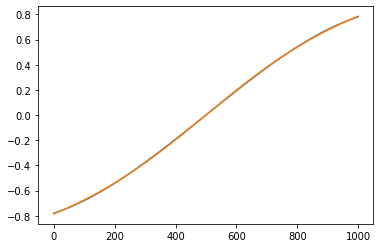

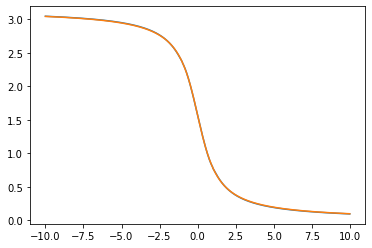

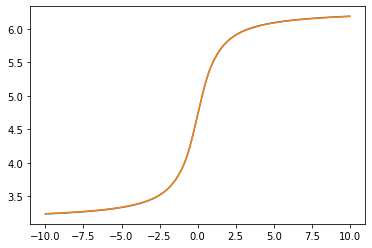

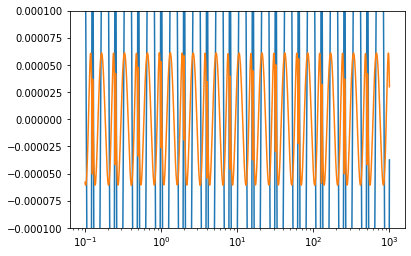

In [910]:
plt.plot(atan_app)
plt.plot(atan_ex)
plt.show()

plt.plot(x,atan2p_app)
plt.plot(x,atan2p_ex)
plt.show()

plt.plot(x,atan2m_app)
plt.plot(x,np.pi+atan2m_ex)
plt.show()

plt.semilogx(z,ln_app3a-ln_ex)
#plt.semilogx(z,ln_app3b/ln_ex-1)
plt.semilogx(z,ln_app4a-ln_ex)
#plt.semilogx(z,ln_app4b/ln_ex-1)
plt.ylim(-0.0001,0.0001)
plt.show()

In [888]:
np.arctan2(1000,-1)

1.5717963264615635

In [911]:
ndat = pickle_load("/cosma7/data/dp004/dc-port3/Analysis/NPOINTFFT/OrpheusTest/TreeCorrCompare/LOS1_ggg_orpheusd20_shuffle3.fits")

/cosma/local/pythonconda3/2020-02/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


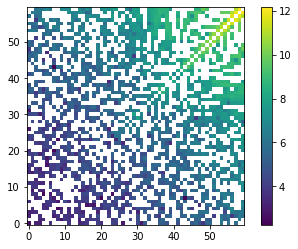

In [873]:
plt.imshow(np.log10(np.real(ndat["Multipoles_norm"][30,0])), origin="lower")
plt.colorbar()
plt.show()

In [912]:
ndat["Pars"]

{'min_sep': 0.5,
 'max_sep': 200.0,
 'binsize': 0.0998577424517996,
 'nbinsr': 60,
 'rmin_pixsize': 20,
 'dpixs': array([0.  , 0.25, 0.5 , 1.  , 2.  ]),
 'method': 'DoubleTree',
 'nthreads': 16,
 'time': 505.9377920627594,
 'dotomo': False,
 'cat': '/cosma7/data/dp004/dc-port3/Data/SLICS/KiDS450/GalCatalog_LOS1.fits'}